In [1]:
import giraffe
import matplotlib.pyplot as plt
from netZooPy.otter.otter import otter
from netZooPy.panda import Panda
import notebooks
import numpy as np
import pandas as pd
from data.lung import preprocessing
from sklearn.metrics import roc_curve, auc

In [2]:
cache = True

In [3]:
if not cache:
    preprocessing.generate_data() 
expression = pd.read_csv("data/lung/raw/expression.csv", index_col = 0)
motif = pd.read_csv("data/lung/motif.csv", index_col = 0)
ppi = pd.read_csv("data/lung/ppi_matrix.csv", index_col = 0)
chip = pd.read_csv("data/lung/chip.csv", index_col = 0)

In [4]:
print(expression.shape)
print(motif.shape)
print(ppi.shape)
print(chip.shape)

(30243, 360)
(30243, 644)
(644, 644)
(30243, 644)


### 2.1 GIRAFFE

In [5]:
if cache:
    R_giraffe = pd.read_csv("data/lung/R_giraffe.csv", index_col = 0)
else:
    R_giraffe = giraffe.Giraffe(expression.to_numpy(), motif.to_numpy(), ppi.to_numpy() + np.eye(ppi.shape[0]), save_computation = True).get_regulation()
    pd.DataFrame(R_giraffe, index = motif.index, columns = motif.columns).to_csv("data/lung/R_giraffe.csv")

### 2.2 OTTER [2]

In [6]:
if cache:
    R_otter = pd.read_csv("data/lung/R_otter.csv", index_col = 0)
else:
    R_otter = otter(motif.T.to_numpy(), ppi.to_numpy() + np.eye(ppi.shape[0]), np.corrcoef(expression.to_numpy())).T
    pd.DataFrame(R_otter, index = motif.index, columns = motif.columns).to_csv("data/lung/R_otter.csv")

### 2.3 PANDA [1]

In [7]:
R_panda_raw = pd.read_csv("data/lung/R_panda.csv", index_col = 0).T
R_panda = pd.DataFrame(0, index = motif.index, columns = motif.columns)
for g in R_panda_raw.index:
    for tf in R_panda_raw.columns:
        R_panda.at[g, tf] = R_panda_raw.at[g, tf]

### 2.4 Motif-based prior

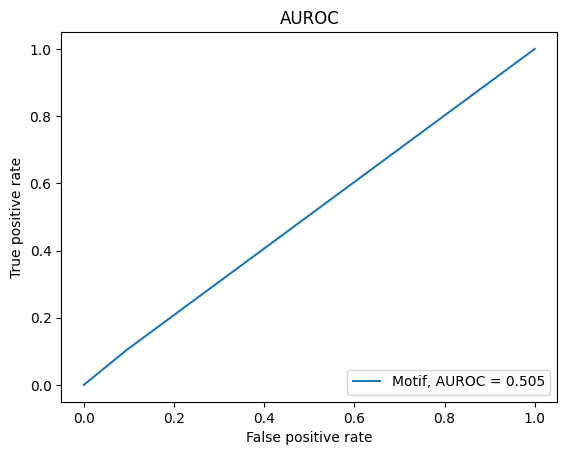

[0.505]

In [8]:
notebooks.plot_auroc(chip.to_numpy().flatten(), [motif.to_numpy().flatten()], ['Motif'])

### 2.5 GENIE3 [3]

In [9]:
model = notebooks.GENIE3(expression.to_numpy().T, gene_names = list(expression.index) ,regulators = list(expression.index), ntrees=5)

Tree method: RF
K: sqrt
Number of trees: 5


running single threaded jobs
Gene 1/30243...
Gene 2/30243...
Gene 3/30243...
Gene 4/30243...
Gene 5/30243...
Gene 6/30243...
Gene 7/30243...
Gene 8/30243...
Gene 9/30243...
Gene 10/30243...
Gene 11/30243...
Gene 12/30243...
Gene 13/30243...
Gene 14/30243...
Gene 15/30243...
Gene 16/30243...
Gene 17/30243...
Gene 18/30243...
Gene 19/30243...
Gene 20/30243...
Gene 21/30243...
Gene 22/30243...
Gene 23/30243...
Gene 24/30243...
Gene 25/30243...
Gene 26/30243...
Gene 27/30243...
Gene 28/30243...
Gene 29/30243...
Gene 30/30243...
Gene 31/30243...
Gene 32/30243...
Gene 33/30243...
Gene 34/30243...
Gene 35/30243...
Gene 36/30243...
Gene 37/30243...
Gene 38/30243...
Gene 39/30243...
Gene 40/30243...
Gene 41/30243...
Gene 42/30243...
Gene 43/30243...
Gene 44/30243...
Gene 45/30243...
Gene 46/30243...
Gene 47/30243...
Gene 48/30243...
Gene 49/30243...
Gene 50/30243...
Gene 51/30243...
Gene 52/30243...
Gene 53/30243...
Gene 54/30243...
Gene 55/30243...


Gene 459/30243...
Gene 460/30243...
Gene 461/30243...
Gene 462/30243...
Gene 463/30243...
Gene 464/30243...
Gene 465/30243...
Gene 466/30243...
Gene 467/30243...
Gene 468/30243...
Gene 469/30243...
Gene 470/30243...
Gene 471/30243...
Gene 472/30243...
Gene 473/30243...
Gene 474/30243...
Gene 475/30243...
Gene 476/30243...
Gene 477/30243...
Gene 478/30243...
Gene 479/30243...
Gene 480/30243...
Gene 481/30243...
Gene 482/30243...
Gene 483/30243...
Gene 484/30243...
Gene 485/30243...
Gene 486/30243...
Gene 487/30243...
Gene 488/30243...
Gene 489/30243...
Gene 490/30243...
Gene 491/30243...
Gene 492/30243...
Gene 493/30243...
Gene 494/30243...
Gene 495/30243...
Gene 496/30243...
Gene 497/30243...
Gene 498/30243...
Gene 499/30243...
Gene 500/30243...
Gene 501/30243...
Gene 502/30243...
Gene 503/30243...
Gene 504/30243...
Gene 505/30243...
Gene 506/30243...
Gene 507/30243...
Gene 508/30243...
Gene 509/30243...
Gene 510/30243...
Gene 511/30243...
Gene 512/30243...
Gene 513/30243...
Gene 514/3

Gene 915/30243...
Gene 916/30243...
Gene 917/30243...
Gene 918/30243...
Gene 919/30243...
Gene 920/30243...
Gene 921/30243...
Gene 922/30243...
Gene 923/30243...
Gene 924/30243...
Gene 925/30243...
Gene 926/30243...
Gene 927/30243...
Gene 928/30243...
Gene 929/30243...
Gene 930/30243...
Gene 931/30243...
Gene 932/30243...
Gene 933/30243...
Gene 934/30243...
Gene 935/30243...
Gene 936/30243...
Gene 937/30243...
Gene 938/30243...
Gene 939/30243...
Gene 940/30243...
Gene 941/30243...
Gene 942/30243...
Gene 943/30243...
Gene 944/30243...
Gene 945/30243...
Gene 946/30243...
Gene 947/30243...
Gene 948/30243...
Gene 949/30243...
Gene 950/30243...
Gene 951/30243...
Gene 952/30243...
Gene 953/30243...
Gene 954/30243...
Gene 955/30243...
Gene 956/30243...
Gene 957/30243...
Gene 958/30243...
Gene 959/30243...
Gene 960/30243...
Gene 961/30243...
Gene 962/30243...
Gene 963/30243...
Gene 964/30243...
Gene 965/30243...
Gene 966/30243...
Gene 967/30243...
Gene 968/30243...
Gene 969/30243...
Gene 970/3

Gene 1351/30243...
Gene 1352/30243...
Gene 1353/30243...
Gene 1354/30243...
Gene 1355/30243...
Gene 1356/30243...
Gene 1357/30243...
Gene 1358/30243...
Gene 1359/30243...
Gene 1360/30243...
Gene 1361/30243...
Gene 1362/30243...
Gene 1363/30243...
Gene 1364/30243...
Gene 1365/30243...
Gene 1366/30243...
Gene 1367/30243...
Gene 1368/30243...
Gene 1369/30243...
Gene 1370/30243...
Gene 1371/30243...
Gene 1372/30243...
Gene 1373/30243...
Gene 1374/30243...
Gene 1375/30243...
Gene 1376/30243...
Gene 1377/30243...
Gene 1378/30243...
Gene 1379/30243...
Gene 1380/30243...
Gene 1381/30243...
Gene 1382/30243...
Gene 1383/30243...
Gene 1384/30243...
Gene 1385/30243...
Gene 1386/30243...
Gene 1387/30243...
Gene 1388/30243...
Gene 1389/30243...
Gene 1390/30243...
Gene 1391/30243...
Gene 1392/30243...
Gene 1393/30243...
Gene 1394/30243...
Gene 1395/30243...
Gene 1396/30243...
Gene 1397/30243...
Gene 1398/30243...
Gene 1399/30243...
Gene 1400/30243...
Gene 1401/30243...
Gene 1402/30243...
Gene 1403/30

Gene 1783/30243...
Gene 1784/30243...
Gene 1785/30243...
Gene 1786/30243...
Gene 1787/30243...
Gene 1788/30243...
Gene 1789/30243...
Gene 1790/30243...
Gene 1791/30243...
Gene 1792/30243...
Gene 1793/30243...
Gene 1794/30243...
Gene 1795/30243...
Gene 1796/30243...
Gene 1797/30243...
Gene 1798/30243...
Gene 1799/30243...
Gene 1800/30243...
Gene 1801/30243...
Gene 1802/30243...
Gene 1803/30243...
Gene 1804/30243...
Gene 1805/30243...
Gene 1806/30243...
Gene 1807/30243...
Gene 1808/30243...
Gene 1809/30243...
Gene 1810/30243...
Gene 1811/30243...
Gene 1812/30243...
Gene 1813/30243...
Gene 1814/30243...
Gene 1815/30243...
Gene 1816/30243...
Gene 1817/30243...
Gene 1818/30243...
Gene 1819/30243...
Gene 1820/30243...
Gene 1821/30243...
Gene 1822/30243...
Gene 1823/30243...
Gene 1824/30243...
Gene 1825/30243...
Gene 1826/30243...
Gene 1827/30243...
Gene 1828/30243...
Gene 1829/30243...
Gene 1830/30243...
Gene 1831/30243...
Gene 1832/30243...
Gene 1833/30243...
Gene 1834/30243...
Gene 1835/30

Gene 2215/30243...
Gene 2216/30243...
Gene 2217/30243...
Gene 2218/30243...
Gene 2219/30243...
Gene 2220/30243...
Gene 2221/30243...
Gene 2222/30243...
Gene 2223/30243...
Gene 2224/30243...
Gene 2225/30243...
Gene 2226/30243...
Gene 2227/30243...
Gene 2228/30243...
Gene 2229/30243...
Gene 2230/30243...
Gene 2231/30243...
Gene 2232/30243...
Gene 2233/30243...
Gene 2234/30243...
Gene 2235/30243...
Gene 2236/30243...
Gene 2237/30243...
Gene 2238/30243...
Gene 2239/30243...
Gene 2240/30243...
Gene 2241/30243...
Gene 2242/30243...
Gene 2243/30243...
Gene 2244/30243...
Gene 2245/30243...
Gene 2246/30243...
Gene 2247/30243...
Gene 2248/30243...
Gene 2249/30243...
Gene 2250/30243...
Gene 2251/30243...
Gene 2252/30243...
Gene 2253/30243...
Gene 2254/30243...
Gene 2255/30243...
Gene 2256/30243...
Gene 2257/30243...
Gene 2258/30243...
Gene 2259/30243...
Gene 2260/30243...
Gene 2261/30243...
Gene 2262/30243...
Gene 2263/30243...
Gene 2264/30243...
Gene 2265/30243...
Gene 2266/30243...
Gene 2267/30

Gene 2647/30243...
Gene 2648/30243...
Gene 2649/30243...
Gene 2650/30243...
Gene 2651/30243...
Gene 2652/30243...
Gene 2653/30243...
Gene 2654/30243...
Gene 2655/30243...
Gene 2656/30243...
Gene 2657/30243...
Gene 2658/30243...
Gene 2659/30243...
Gene 2660/30243...
Gene 2661/30243...
Gene 2662/30243...
Gene 2663/30243...
Gene 2664/30243...
Gene 2665/30243...
Gene 2666/30243...
Gene 2667/30243...
Gene 2668/30243...
Gene 2669/30243...
Gene 2670/30243...
Gene 2671/30243...
Gene 2672/30243...
Gene 2673/30243...
Gene 2674/30243...
Gene 2675/30243...
Gene 2676/30243...
Gene 2677/30243...
Gene 2678/30243...
Gene 2679/30243...
Gene 2680/30243...
Gene 2681/30243...
Gene 2682/30243...
Gene 2683/30243...
Gene 2684/30243...
Gene 2685/30243...
Gene 2686/30243...
Gene 2687/30243...
Gene 2688/30243...
Gene 2689/30243...
Gene 2690/30243...
Gene 2691/30243...
Gene 2692/30243...
Gene 2693/30243...
Gene 2694/30243...
Gene 2695/30243...
Gene 2696/30243...
Gene 2697/30243...
Gene 2698/30243...
Gene 2699/30

Gene 3080/30243...
Gene 3081/30243...
Gene 3082/30243...
Gene 3083/30243...
Gene 3084/30243...
Gene 3085/30243...
Gene 3086/30243...
Gene 3087/30243...
Gene 3088/30243...
Gene 3089/30243...
Gene 3090/30243...
Gene 3091/30243...
Gene 3092/30243...
Gene 3093/30243...
Gene 3094/30243...
Gene 3095/30243...
Gene 3096/30243...
Gene 3097/30243...
Gene 3098/30243...
Gene 3099/30243...
Gene 3100/30243...
Gene 3101/30243...
Gene 3102/30243...
Gene 3103/30243...
Gene 3104/30243...
Gene 3105/30243...
Gene 3106/30243...
Gene 3107/30243...
Gene 3108/30243...
Gene 3109/30243...
Gene 3110/30243...
Gene 3111/30243...
Gene 3112/30243...
Gene 3113/30243...
Gene 3114/30243...
Gene 3115/30243...
Gene 3116/30243...
Gene 3117/30243...
Gene 3118/30243...
Gene 3119/30243...
Gene 3120/30243...
Gene 3121/30243...
Gene 3122/30243...
Gene 3123/30243...
Gene 3124/30243...
Gene 3125/30243...
Gene 3126/30243...
Gene 3127/30243...
Gene 3128/30243...
Gene 3129/30243...
Gene 3130/30243...
Gene 3131/30243...
Gene 3132/30

Gene 3513/30243...
Gene 3514/30243...
Gene 3515/30243...
Gene 3516/30243...
Gene 3517/30243...
Gene 3518/30243...
Gene 3519/30243...
Gene 3520/30243...
Gene 3521/30243...
Gene 3522/30243...
Gene 3523/30243...
Gene 3524/30243...
Gene 3525/30243...
Gene 3526/30243...
Gene 3527/30243...
Gene 3528/30243...
Gene 3529/30243...
Gene 3530/30243...
Gene 3531/30243...
Gene 3532/30243...
Gene 3533/30243...
Gene 3534/30243...
Gene 3535/30243...
Gene 3536/30243...
Gene 3537/30243...
Gene 3538/30243...
Gene 3539/30243...
Gene 3540/30243...
Gene 3541/30243...
Gene 3542/30243...
Gene 3543/30243...
Gene 3544/30243...
Gene 3545/30243...
Gene 3546/30243...
Gene 3547/30243...
Gene 3548/30243...
Gene 3549/30243...
Gene 3550/30243...
Gene 3551/30243...
Gene 3552/30243...
Gene 3553/30243...
Gene 3554/30243...
Gene 3555/30243...
Gene 3556/30243...
Gene 3557/30243...
Gene 3558/30243...
Gene 3559/30243...
Gene 3560/30243...
Gene 3561/30243...
Gene 3562/30243...
Gene 3563/30243...
Gene 3564/30243...
Gene 3565/30

Gene 3946/30243...
Gene 3947/30243...
Gene 3948/30243...
Gene 3949/30243...
Gene 3950/30243...
Gene 3951/30243...
Gene 3952/30243...
Gene 3953/30243...
Gene 3954/30243...
Gene 3955/30243...
Gene 3956/30243...
Gene 3957/30243...
Gene 3958/30243...
Gene 3959/30243...
Gene 3960/30243...
Gene 3961/30243...
Gene 3962/30243...
Gene 3963/30243...
Gene 3964/30243...
Gene 3965/30243...
Gene 3966/30243...
Gene 3967/30243...
Gene 3968/30243...
Gene 3969/30243...
Gene 3970/30243...
Gene 3971/30243...
Gene 3972/30243...
Gene 3973/30243...
Gene 3974/30243...
Gene 3975/30243...
Gene 3976/30243...
Gene 3977/30243...
Gene 3978/30243...
Gene 3979/30243...
Gene 3980/30243...
Gene 3981/30243...
Gene 3982/30243...
Gene 3983/30243...
Gene 3984/30243...
Gene 3985/30243...
Gene 3986/30243...
Gene 3987/30243...
Gene 3988/30243...
Gene 3989/30243...
Gene 3990/30243...
Gene 3991/30243...
Gene 3992/30243...
Gene 3993/30243...
Gene 3994/30243...
Gene 3995/30243...
Gene 3996/30243...
Gene 3997/30243...
Gene 3998/30

Gene 4378/30243...
Gene 4379/30243...
Gene 4380/30243...
Gene 4381/30243...
Gene 4382/30243...
Gene 4383/30243...
Gene 4384/30243...
Gene 4385/30243...
Gene 4386/30243...
Gene 4387/30243...
Gene 4388/30243...
Gene 4389/30243...
Gene 4390/30243...
Gene 4391/30243...
Gene 4392/30243...
Gene 4393/30243...
Gene 4394/30243...
Gene 4395/30243...
Gene 4396/30243...
Gene 4397/30243...
Gene 4398/30243...
Gene 4399/30243...
Gene 4400/30243...
Gene 4401/30243...
Gene 4402/30243...
Gene 4403/30243...
Gene 4404/30243...
Gene 4405/30243...
Gene 4406/30243...
Gene 4407/30243...
Gene 4408/30243...
Gene 4409/30243...
Gene 4410/30243...
Gene 4411/30243...
Gene 4412/30243...
Gene 4413/30243...
Gene 4414/30243...
Gene 4415/30243...
Gene 4416/30243...
Gene 4417/30243...
Gene 4418/30243...
Gene 4419/30243...
Gene 4420/30243...
Gene 4421/30243...
Gene 4422/30243...
Gene 4423/30243...
Gene 4424/30243...
Gene 4425/30243...
Gene 4426/30243...
Gene 4427/30243...
Gene 4428/30243...
Gene 4429/30243...
Gene 4430/30

Gene 4811/30243...
Gene 4812/30243...
Gene 4813/30243...
Gene 4814/30243...
Gene 4815/30243...
Gene 4816/30243...
Gene 4817/30243...
Gene 4818/30243...
Gene 4819/30243...
Gene 4820/30243...
Gene 4821/30243...
Gene 4822/30243...
Gene 4823/30243...
Gene 4824/30243...
Gene 4825/30243...
Gene 4826/30243...
Gene 4827/30243...
Gene 4828/30243...
Gene 4829/30243...
Gene 4830/30243...
Gene 4831/30243...
Gene 4832/30243...
Gene 4833/30243...
Gene 4834/30243...
Gene 4835/30243...
Gene 4836/30243...
Gene 4837/30243...
Gene 4838/30243...
Gene 4839/30243...
Gene 4840/30243...
Gene 4841/30243...
Gene 4842/30243...
Gene 4843/30243...
Gene 4844/30243...
Gene 4845/30243...
Gene 4846/30243...
Gene 4847/30243...
Gene 4848/30243...
Gene 4849/30243...
Gene 4850/30243...
Gene 4851/30243...
Gene 4852/30243...
Gene 4853/30243...
Gene 4854/30243...
Gene 4855/30243...
Gene 4856/30243...
Gene 4857/30243...
Gene 4858/30243...
Gene 4859/30243...
Gene 4860/30243...
Gene 4861/30243...
Gene 4862/30243...
Gene 4863/30

Gene 5244/30243...
Gene 5245/30243...
Gene 5246/30243...
Gene 5247/30243...
Gene 5248/30243...
Gene 5249/30243...
Gene 5250/30243...
Gene 5251/30243...
Gene 5252/30243...
Gene 5253/30243...
Gene 5254/30243...
Gene 5255/30243...
Gene 5256/30243...
Gene 5257/30243...
Gene 5258/30243...
Gene 5259/30243...
Gene 5260/30243...
Gene 5261/30243...
Gene 5262/30243...
Gene 5263/30243...
Gene 5264/30243...
Gene 5265/30243...
Gene 5266/30243...
Gene 5267/30243...
Gene 5268/30243...
Gene 5269/30243...
Gene 5270/30243...
Gene 5271/30243...
Gene 5272/30243...
Gene 5273/30243...
Gene 5274/30243...
Gene 5275/30243...
Gene 5276/30243...
Gene 5277/30243...
Gene 5278/30243...
Gene 5279/30243...
Gene 5280/30243...
Gene 5281/30243...
Gene 5282/30243...
Gene 5283/30243...
Gene 5284/30243...
Gene 5285/30243...
Gene 5286/30243...
Gene 5287/30243...
Gene 5288/30243...
Gene 5289/30243...
Gene 5290/30243...
Gene 5291/30243...
Gene 5292/30243...
Gene 5293/30243...
Gene 5294/30243...
Gene 5295/30243...
Gene 5296/30

Gene 5676/30243...
Gene 5677/30243...
Gene 5678/30243...
Gene 5679/30243...
Gene 5680/30243...
Gene 5681/30243...
Gene 5682/30243...
Gene 5683/30243...
Gene 5684/30243...
Gene 5685/30243...
Gene 5686/30243...
Gene 5687/30243...
Gene 5688/30243...
Gene 5689/30243...
Gene 5690/30243...
Gene 5691/30243...
Gene 5692/30243...
Gene 5693/30243...
Gene 5694/30243...
Gene 5695/30243...
Gene 5696/30243...
Gene 5697/30243...
Gene 5698/30243...
Gene 5699/30243...
Gene 5700/30243...
Gene 5701/30243...
Gene 5702/30243...
Gene 5703/30243...
Gene 5704/30243...
Gene 5705/30243...
Gene 5706/30243...
Gene 5707/30243...
Gene 5708/30243...
Gene 5709/30243...
Gene 5710/30243...
Gene 5711/30243...
Gene 5712/30243...
Gene 5713/30243...
Gene 5714/30243...
Gene 5715/30243...
Gene 5716/30243...
Gene 5717/30243...
Gene 5718/30243...
Gene 5719/30243...
Gene 5720/30243...
Gene 5721/30243...
Gene 5722/30243...
Gene 5723/30243...
Gene 5724/30243...
Gene 5725/30243...
Gene 5726/30243...
Gene 5727/30243...
Gene 5728/30

Gene 6108/30243...
Gene 6109/30243...
Gene 6110/30243...
Gene 6111/30243...
Gene 6112/30243...
Gene 6113/30243...
Gene 6114/30243...
Gene 6115/30243...
Gene 6116/30243...
Gene 6117/30243...
Gene 6118/30243...
Gene 6119/30243...
Gene 6120/30243...
Gene 6121/30243...
Gene 6122/30243...
Gene 6123/30243...
Gene 6124/30243...
Gene 6125/30243...
Gene 6126/30243...
Gene 6127/30243...
Gene 6128/30243...
Gene 6129/30243...
Gene 6130/30243...
Gene 6131/30243...
Gene 6132/30243...
Gene 6133/30243...
Gene 6134/30243...
Gene 6135/30243...
Gene 6136/30243...
Gene 6137/30243...
Gene 6138/30243...
Gene 6139/30243...
Gene 6140/30243...
Gene 6141/30243...
Gene 6142/30243...
Gene 6143/30243...
Gene 6144/30243...
Gene 6145/30243...
Gene 6146/30243...
Gene 6147/30243...
Gene 6148/30243...
Gene 6149/30243...
Gene 6150/30243...
Gene 6151/30243...
Gene 6152/30243...
Gene 6153/30243...
Gene 6154/30243...
Gene 6155/30243...
Gene 6156/30243...
Gene 6157/30243...
Gene 6158/30243...
Gene 6159/30243...
Gene 6160/30

Gene 6541/30243...
Gene 6542/30243...
Gene 6543/30243...
Gene 6544/30243...
Gene 6545/30243...
Gene 6546/30243...
Gene 6547/30243...
Gene 6548/30243...
Gene 6549/30243...
Gene 6550/30243...
Gene 6551/30243...
Gene 6552/30243...
Gene 6553/30243...
Gene 6554/30243...
Gene 6555/30243...
Gene 6556/30243...
Gene 6557/30243...
Gene 6558/30243...
Gene 6559/30243...
Gene 6560/30243...
Gene 6561/30243...
Gene 6562/30243...
Gene 6563/30243...
Gene 6564/30243...
Gene 6565/30243...
Gene 6566/30243...
Gene 6567/30243...
Gene 6568/30243...
Gene 6569/30243...
Gene 6570/30243...
Gene 6571/30243...
Gene 6572/30243...
Gene 6573/30243...
Gene 6574/30243...
Gene 6575/30243...
Gene 6576/30243...
Gene 6577/30243...
Gene 6578/30243...
Gene 6579/30243...
Gene 6580/30243...
Gene 6581/30243...
Gene 6582/30243...
Gene 6583/30243...
Gene 6584/30243...
Gene 6585/30243...
Gene 6586/30243...
Gene 6587/30243...
Gene 6588/30243...
Gene 6589/30243...
Gene 6590/30243...
Gene 6591/30243...
Gene 6592/30243...
Gene 6593/30

Gene 6973/30243...
Gene 6974/30243...
Gene 6975/30243...
Gene 6976/30243...
Gene 6977/30243...
Gene 6978/30243...
Gene 6979/30243...
Gene 6980/30243...
Gene 6981/30243...
Gene 6982/30243...
Gene 6983/30243...
Gene 6984/30243...
Gene 6985/30243...
Gene 6986/30243...
Gene 6987/30243...
Gene 6988/30243...
Gene 6989/30243...
Gene 6990/30243...
Gene 6991/30243...
Gene 6992/30243...
Gene 6993/30243...
Gene 6994/30243...
Gene 6995/30243...
Gene 6996/30243...
Gene 6997/30243...
Gene 6998/30243...
Gene 6999/30243...
Gene 7000/30243...
Gene 7001/30243...
Gene 7002/30243...
Gene 7003/30243...
Gene 7004/30243...
Gene 7005/30243...
Gene 7006/30243...
Gene 7007/30243...
Gene 7008/30243...
Gene 7009/30243...
Gene 7010/30243...
Gene 7011/30243...
Gene 7012/30243...
Gene 7013/30243...
Gene 7014/30243...
Gene 7015/30243...
Gene 7016/30243...
Gene 7017/30243...
Gene 7018/30243...
Gene 7019/30243...
Gene 7020/30243...
Gene 7021/30243...
Gene 7022/30243...
Gene 7023/30243...
Gene 7024/30243...
Gene 7025/30

Gene 7405/30243...
Gene 7406/30243...
Gene 7407/30243...
Gene 7408/30243...
Gene 7409/30243...
Gene 7410/30243...
Gene 7411/30243...
Gene 7412/30243...
Gene 7413/30243...
Gene 7414/30243...
Gene 7415/30243...
Gene 7416/30243...
Gene 7417/30243...
Gene 7418/30243...
Gene 7419/30243...
Gene 7420/30243...
Gene 7421/30243...
Gene 7422/30243...
Gene 7423/30243...
Gene 7424/30243...
Gene 7425/30243...
Gene 7426/30243...
Gene 7427/30243...
Gene 7428/30243...
Gene 7429/30243...
Gene 7430/30243...
Gene 7431/30243...
Gene 7432/30243...
Gene 7433/30243...
Gene 7434/30243...
Gene 7435/30243...
Gene 7436/30243...
Gene 7437/30243...
Gene 7438/30243...
Gene 7439/30243...
Gene 7440/30243...
Gene 7441/30243...
Gene 7442/30243...
Gene 7443/30243...
Gene 7444/30243...
Gene 7445/30243...
Gene 7446/30243...
Gene 7447/30243...
Gene 7448/30243...
Gene 7449/30243...
Gene 7450/30243...
Gene 7451/30243...
Gene 7452/30243...
Gene 7453/30243...
Gene 7454/30243...
Gene 7455/30243...
Gene 7456/30243...
Gene 7457/30

Gene 7837/30243...
Gene 7838/30243...
Gene 7839/30243...
Gene 7840/30243...
Gene 7841/30243...
Gene 7842/30243...
Gene 7843/30243...
Gene 7844/30243...
Gene 7845/30243...
Gene 7846/30243...
Gene 7847/30243...
Gene 7848/30243...
Gene 7849/30243...
Gene 7850/30243...
Gene 7851/30243...
Gene 7852/30243...
Gene 7853/30243...
Gene 7854/30243...
Gene 7855/30243...
Gene 7856/30243...
Gene 7857/30243...
Gene 7858/30243...
Gene 7859/30243...
Gene 7860/30243...
Gene 7861/30243...
Gene 7862/30243...
Gene 7863/30243...
Gene 7864/30243...
Gene 7865/30243...
Gene 7866/30243...
Gene 7867/30243...
Gene 7868/30243...
Gene 7869/30243...
Gene 7870/30243...
Gene 7871/30243...
Gene 7872/30243...
Gene 7873/30243...
Gene 7874/30243...
Gene 7875/30243...
Gene 7876/30243...
Gene 7877/30243...
Gene 7878/30243...
Gene 7879/30243...
Gene 7880/30243...
Gene 7881/30243...
Gene 7882/30243...
Gene 7883/30243...
Gene 7884/30243...
Gene 7885/30243...
Gene 7886/30243...
Gene 7887/30243...
Gene 7888/30243...
Gene 7889/30

Gene 8269/30243...
Gene 8270/30243...
Gene 8271/30243...
Gene 8272/30243...
Gene 8273/30243...
Gene 8274/30243...
Gene 8275/30243...
Gene 8276/30243...
Gene 8277/30243...
Gene 8278/30243...
Gene 8279/30243...
Gene 8280/30243...
Gene 8281/30243...
Gene 8282/30243...
Gene 8283/30243...
Gene 8284/30243...
Gene 8285/30243...
Gene 8286/30243...
Gene 8287/30243...
Gene 8288/30243...
Gene 8289/30243...
Gene 8290/30243...
Gene 8291/30243...
Gene 8292/30243...
Gene 8293/30243...
Gene 8294/30243...
Gene 8295/30243...
Gene 8296/30243...
Gene 8297/30243...
Gene 8298/30243...
Gene 8299/30243...
Gene 8300/30243...
Gene 8301/30243...
Gene 8302/30243...
Gene 8303/30243...
Gene 8304/30243...
Gene 8305/30243...
Gene 8306/30243...
Gene 8307/30243...
Gene 8308/30243...
Gene 8309/30243...
Gene 8310/30243...
Gene 8311/30243...
Gene 8312/30243...
Gene 8313/30243...
Gene 8314/30243...
Gene 8315/30243...
Gene 8316/30243...
Gene 8317/30243...
Gene 8318/30243...
Gene 8319/30243...
Gene 8320/30243...
Gene 8321/30

Gene 8701/30243...
Gene 8702/30243...
Gene 8703/30243...
Gene 8704/30243...
Gene 8705/30243...
Gene 8706/30243...
Gene 8707/30243...
Gene 8708/30243...
Gene 8709/30243...
Gene 8710/30243...
Gene 8711/30243...
Gene 8712/30243...
Gene 8713/30243...
Gene 8714/30243...
Gene 8715/30243...
Gene 8716/30243...
Gene 8717/30243...
Gene 8718/30243...
Gene 8719/30243...
Gene 8720/30243...
Gene 8721/30243...
Gene 8722/30243...
Gene 8723/30243...
Gene 8724/30243...
Gene 8725/30243...
Gene 8726/30243...
Gene 8727/30243...
Gene 8728/30243...
Gene 8729/30243...
Gene 8730/30243...
Gene 8731/30243...
Gene 8732/30243...
Gene 8733/30243...
Gene 8734/30243...
Gene 8735/30243...
Gene 8736/30243...
Gene 8737/30243...
Gene 8738/30243...
Gene 8739/30243...
Gene 8740/30243...
Gene 8741/30243...
Gene 8742/30243...
Gene 8743/30243...
Gene 8744/30243...
Gene 8745/30243...
Gene 8746/30243...
Gene 8747/30243...
Gene 8748/30243...
Gene 8749/30243...
Gene 8750/30243...
Gene 8751/30243...
Gene 8752/30243...
Gene 8753/30

Gene 9134/30243...
Gene 9135/30243...
Gene 9136/30243...
Gene 9137/30243...
Gene 9138/30243...
Gene 9139/30243...
Gene 9140/30243...
Gene 9141/30243...
Gene 9142/30243...
Gene 9143/30243...
Gene 9144/30243...
Gene 9145/30243...
Gene 9146/30243...
Gene 9147/30243...
Gene 9148/30243...
Gene 9149/30243...
Gene 9150/30243...
Gene 9151/30243...
Gene 9152/30243...
Gene 9153/30243...
Gene 9154/30243...
Gene 9155/30243...
Gene 9156/30243...
Gene 9157/30243...
Gene 9158/30243...
Gene 9159/30243...
Gene 9160/30243...
Gene 9161/30243...
Gene 9162/30243...
Gene 9163/30243...
Gene 9164/30243...
Gene 9165/30243...
Gene 9166/30243...
Gene 9167/30243...
Gene 9168/30243...
Gene 9169/30243...
Gene 9170/30243...
Gene 9171/30243...
Gene 9172/30243...
Gene 9173/30243...
Gene 9174/30243...
Gene 9175/30243...
Gene 9176/30243...
Gene 9177/30243...
Gene 9178/30243...
Gene 9179/30243...
Gene 9180/30243...
Gene 9181/30243...
Gene 9182/30243...
Gene 9183/30243...
Gene 9184/30243...
Gene 9185/30243...
Gene 9186/30

Gene 9567/30243...
Gene 9568/30243...
Gene 9569/30243...
Gene 9570/30243...
Gene 9571/30243...
Gene 9572/30243...
Gene 9573/30243...
Gene 9574/30243...
Gene 9575/30243...
Gene 9576/30243...
Gene 9577/30243...
Gene 9578/30243...
Gene 9579/30243...
Gene 9580/30243...
Gene 9581/30243...
Gene 9582/30243...
Gene 9583/30243...
Gene 9584/30243...
Gene 9585/30243...
Gene 9586/30243...
Gene 9587/30243...
Gene 9588/30243...
Gene 9589/30243...
Gene 9590/30243...
Gene 9591/30243...
Gene 9592/30243...
Gene 9593/30243...
Gene 9594/30243...
Gene 9595/30243...
Gene 9596/30243...
Gene 9597/30243...
Gene 9598/30243...
Gene 9599/30243...
Gene 9600/30243...
Gene 9601/30243...
Gene 9602/30243...
Gene 9603/30243...
Gene 9604/30243...
Gene 9605/30243...
Gene 9606/30243...
Gene 9607/30243...
Gene 9608/30243...
Gene 9609/30243...
Gene 9610/30243...
Gene 9611/30243...
Gene 9612/30243...
Gene 9613/30243...
Gene 9614/30243...
Gene 9615/30243...
Gene 9616/30243...
Gene 9617/30243...
Gene 9618/30243...
Gene 9619/30

Gene 9999/30243...
Gene 10000/30243...
Gene 10001/30243...
Gene 10002/30243...
Gene 10003/30243...
Gene 10004/30243...
Gene 10005/30243...
Gene 10006/30243...
Gene 10007/30243...
Gene 10008/30243...
Gene 10009/30243...
Gene 10010/30243...
Gene 10011/30243...
Gene 10012/30243...
Gene 10013/30243...
Gene 10014/30243...
Gene 10015/30243...
Gene 10016/30243...
Gene 10017/30243...
Gene 10018/30243...
Gene 10019/30243...
Gene 10020/30243...
Gene 10021/30243...
Gene 10022/30243...
Gene 10023/30243...
Gene 10024/30243...
Gene 10025/30243...
Gene 10026/30243...
Gene 10027/30243...
Gene 10028/30243...
Gene 10029/30243...
Gene 10030/30243...
Gene 10031/30243...
Gene 10032/30243...
Gene 10033/30243...
Gene 10034/30243...
Gene 10035/30243...
Gene 10036/30243...
Gene 10037/30243...
Gene 10038/30243...
Gene 10039/30243...
Gene 10040/30243...
Gene 10041/30243...
Gene 10042/30243...
Gene 10043/30243...
Gene 10044/30243...
Gene 10045/30243...
Gene 10046/30243...
Gene 10047/30243...
Gene 10048/30243...
G

Gene 10410/30243...
Gene 10411/30243...
Gene 10412/30243...
Gene 10413/30243...
Gene 10414/30243...
Gene 10415/30243...
Gene 10416/30243...
Gene 10417/30243...
Gene 10418/30243...
Gene 10419/30243...
Gene 10420/30243...
Gene 10421/30243...
Gene 10422/30243...
Gene 10423/30243...
Gene 10424/30243...
Gene 10425/30243...
Gene 10426/30243...
Gene 10427/30243...
Gene 10428/30243...
Gene 10429/30243...
Gene 10430/30243...
Gene 10431/30243...
Gene 10432/30243...
Gene 10433/30243...
Gene 10434/30243...
Gene 10435/30243...
Gene 10436/30243...
Gene 10437/30243...
Gene 10438/30243...
Gene 10439/30243...
Gene 10440/30243...
Gene 10441/30243...
Gene 10442/30243...
Gene 10443/30243...
Gene 10444/30243...
Gene 10445/30243...
Gene 10446/30243...
Gene 10447/30243...
Gene 10448/30243...
Gene 10449/30243...
Gene 10450/30243...
Gene 10451/30243...
Gene 10452/30243...
Gene 10453/30243...
Gene 10454/30243...
Gene 10455/30243...
Gene 10456/30243...
Gene 10457/30243...
Gene 10458/30243...
Gene 10459/30243...


Gene 10820/30243...
Gene 10821/30243...
Gene 10822/30243...
Gene 10823/30243...
Gene 10824/30243...
Gene 10825/30243...
Gene 10826/30243...
Gene 10827/30243...
Gene 10828/30243...
Gene 10829/30243...
Gene 10830/30243...
Gene 10831/30243...
Gene 10832/30243...
Gene 10833/30243...
Gene 10834/30243...
Gene 10835/30243...
Gene 10836/30243...
Gene 10837/30243...
Gene 10838/30243...
Gene 10839/30243...
Gene 10840/30243...
Gene 10841/30243...
Gene 10842/30243...
Gene 10843/30243...
Gene 10844/30243...
Gene 10845/30243...
Gene 10846/30243...
Gene 10847/30243...
Gene 10848/30243...
Gene 10849/30243...
Gene 10850/30243...
Gene 10851/30243...
Gene 10852/30243...
Gene 10853/30243...
Gene 10854/30243...
Gene 10855/30243...
Gene 10856/30243...
Gene 10857/30243...
Gene 10858/30243...
Gene 10859/30243...
Gene 10860/30243...
Gene 10861/30243...
Gene 10862/30243...
Gene 10863/30243...
Gene 10864/30243...
Gene 10865/30243...
Gene 10866/30243...
Gene 10867/30243...
Gene 10868/30243...
Gene 10869/30243...


Gene 11231/30243...
Gene 11232/30243...
Gene 11233/30243...
Gene 11234/30243...
Gene 11235/30243...
Gene 11236/30243...
Gene 11237/30243...
Gene 11238/30243...
Gene 11239/30243...
Gene 11240/30243...
Gene 11241/30243...
Gene 11242/30243...
Gene 11243/30243...
Gene 11244/30243...
Gene 11245/30243...
Gene 11246/30243...
Gene 11247/30243...
Gene 11248/30243...
Gene 11249/30243...
Gene 11250/30243...
Gene 11251/30243...
Gene 11252/30243...
Gene 11253/30243...
Gene 11254/30243...
Gene 11255/30243...
Gene 11256/30243...
Gene 11257/30243...
Gene 11258/30243...
Gene 11259/30243...
Gene 11260/30243...
Gene 11261/30243...
Gene 11262/30243...
Gene 11263/30243...
Gene 11264/30243...
Gene 11265/30243...
Gene 11266/30243...
Gene 11267/30243...
Gene 11268/30243...
Gene 11269/30243...
Gene 11270/30243...
Gene 11271/30243...
Gene 11272/30243...
Gene 11273/30243...
Gene 11274/30243...
Gene 11275/30243...
Gene 11276/30243...
Gene 11277/30243...
Gene 11278/30243...
Gene 11279/30243...
Gene 11280/30243...


Gene 11641/30243...
Gene 11642/30243...
Gene 11643/30243...
Gene 11644/30243...
Gene 11645/30243...
Gene 11646/30243...
Gene 11647/30243...
Gene 11648/30243...
Gene 11649/30243...
Gene 11650/30243...
Gene 11651/30243...
Gene 11652/30243...
Gene 11653/30243...
Gene 11654/30243...
Gene 11655/30243...
Gene 11656/30243...
Gene 11657/30243...
Gene 11658/30243...
Gene 11659/30243...
Gene 11660/30243...
Gene 11661/30243...
Gene 11662/30243...
Gene 11663/30243...
Gene 11664/30243...
Gene 11665/30243...
Gene 11666/30243...
Gene 11667/30243...
Gene 11668/30243...
Gene 11669/30243...
Gene 11670/30243...
Gene 11671/30243...
Gene 11672/30243...
Gene 11673/30243...
Gene 11674/30243...
Gene 11675/30243...
Gene 11676/30243...
Gene 11677/30243...
Gene 11678/30243...
Gene 11679/30243...
Gene 11680/30243...
Gene 11681/30243...
Gene 11682/30243...
Gene 11683/30243...
Gene 11684/30243...
Gene 11685/30243...
Gene 11686/30243...
Gene 11687/30243...
Gene 11688/30243...
Gene 11689/30243...
Gene 11690/30243...


Gene 12052/30243...
Gene 12053/30243...
Gene 12054/30243...
Gene 12055/30243...
Gene 12056/30243...
Gene 12057/30243...
Gene 12058/30243...
Gene 12059/30243...
Gene 12060/30243...
Gene 12061/30243...
Gene 12062/30243...
Gene 12063/30243...
Gene 12064/30243...
Gene 12065/30243...
Gene 12066/30243...
Gene 12067/30243...
Gene 12068/30243...
Gene 12069/30243...
Gene 12070/30243...
Gene 12071/30243...
Gene 12072/30243...
Gene 12073/30243...
Gene 12074/30243...
Gene 12075/30243...
Gene 12076/30243...
Gene 12077/30243...
Gene 12078/30243...
Gene 12079/30243...
Gene 12080/30243...
Gene 12081/30243...
Gene 12082/30243...
Gene 12083/30243...
Gene 12084/30243...
Gene 12085/30243...
Gene 12086/30243...
Gene 12087/30243...
Gene 12088/30243...
Gene 12089/30243...
Gene 12090/30243...
Gene 12091/30243...
Gene 12092/30243...
Gene 12093/30243...
Gene 12094/30243...
Gene 12095/30243...
Gene 12096/30243...
Gene 12097/30243...
Gene 12098/30243...
Gene 12099/30243...
Gene 12100/30243...
Gene 12101/30243...


Gene 12463/30243...
Gene 12464/30243...
Gene 12465/30243...
Gene 12466/30243...
Gene 12467/30243...
Gene 12468/30243...
Gene 12469/30243...
Gene 12470/30243...
Gene 12471/30243...
Gene 12472/30243...
Gene 12473/30243...
Gene 12474/30243...
Gene 12475/30243...
Gene 12476/30243...
Gene 12477/30243...
Gene 12478/30243...
Gene 12479/30243...
Gene 12480/30243...
Gene 12481/30243...
Gene 12482/30243...
Gene 12483/30243...
Gene 12484/30243...
Gene 12485/30243...
Gene 12486/30243...
Gene 12487/30243...
Gene 12488/30243...
Gene 12489/30243...
Gene 12490/30243...
Gene 12491/30243...
Gene 12492/30243...
Gene 12493/30243...
Gene 12494/30243...
Gene 12495/30243...
Gene 12496/30243...
Gene 12497/30243...
Gene 12498/30243...
Gene 12499/30243...
Gene 12500/30243...
Gene 12501/30243...
Gene 12502/30243...
Gene 12503/30243...
Gene 12504/30243...
Gene 12505/30243...
Gene 12506/30243...
Gene 12507/30243...
Gene 12508/30243...
Gene 12509/30243...
Gene 12510/30243...
Gene 12511/30243...
Gene 12512/30243...


Gene 12874/30243...
Gene 12875/30243...
Gene 12876/30243...
Gene 12877/30243...
Gene 12878/30243...
Gene 12879/30243...
Gene 12880/30243...
Gene 12881/30243...
Gene 12882/30243...
Gene 12883/30243...
Gene 12884/30243...
Gene 12885/30243...
Gene 12886/30243...
Gene 12887/30243...
Gene 12888/30243...
Gene 12889/30243...
Gene 12890/30243...
Gene 12891/30243...
Gene 12892/30243...
Gene 12893/30243...
Gene 12894/30243...
Gene 12895/30243...
Gene 12896/30243...
Gene 12897/30243...
Gene 12898/30243...
Gene 12899/30243...
Gene 12900/30243...
Gene 12901/30243...
Gene 12902/30243...
Gene 12903/30243...
Gene 12904/30243...
Gene 12905/30243...
Gene 12906/30243...
Gene 12907/30243...
Gene 12908/30243...
Gene 12909/30243...
Gene 12910/30243...
Gene 12911/30243...
Gene 12912/30243...
Gene 12913/30243...
Gene 12914/30243...
Gene 12915/30243...
Gene 12916/30243...
Gene 12917/30243...
Gene 12918/30243...
Gene 12919/30243...
Gene 12920/30243...
Gene 12921/30243...
Gene 12922/30243...
Gene 12923/30243...


Gene 13285/30243...
Gene 13286/30243...
Gene 13287/30243...
Gene 13288/30243...
Gene 13289/30243...
Gene 13290/30243...
Gene 13291/30243...
Gene 13292/30243...
Gene 13293/30243...
Gene 13294/30243...
Gene 13295/30243...
Gene 13296/30243...
Gene 13297/30243...
Gene 13298/30243...
Gene 13299/30243...
Gene 13300/30243...
Gene 13301/30243...
Gene 13302/30243...
Gene 13303/30243...
Gene 13304/30243...
Gene 13305/30243...
Gene 13306/30243...
Gene 13307/30243...
Gene 13308/30243...
Gene 13309/30243...
Gene 13310/30243...
Gene 13311/30243...
Gene 13312/30243...
Gene 13313/30243...
Gene 13314/30243...
Gene 13315/30243...
Gene 13316/30243...
Gene 13317/30243...
Gene 13318/30243...
Gene 13319/30243...
Gene 13320/30243...
Gene 13321/30243...
Gene 13322/30243...
Gene 13323/30243...
Gene 13324/30243...
Gene 13325/30243...
Gene 13326/30243...
Gene 13327/30243...
Gene 13328/30243...
Gene 13329/30243...
Gene 13330/30243...
Gene 13331/30243...
Gene 13332/30243...
Gene 13333/30243...
Gene 13334/30243...


Gene 13695/30243...
Gene 13696/30243...
Gene 13697/30243...
Gene 13698/30243...
Gene 13699/30243...
Gene 13700/30243...
Gene 13701/30243...
Gene 13702/30243...
Gene 13703/30243...
Gene 13704/30243...
Gene 13705/30243...
Gene 13706/30243...
Gene 13707/30243...
Gene 13708/30243...
Gene 13709/30243...
Gene 13710/30243...
Gene 13711/30243...
Gene 13712/30243...
Gene 13713/30243...
Gene 13714/30243...
Gene 13715/30243...
Gene 13716/30243...
Gene 13717/30243...
Gene 13718/30243...
Gene 13719/30243...
Gene 13720/30243...
Gene 13721/30243...
Gene 13722/30243...
Gene 13723/30243...
Gene 13724/30243...
Gene 13725/30243...
Gene 13726/30243...
Gene 13727/30243...
Gene 13728/30243...
Gene 13729/30243...
Gene 13730/30243...
Gene 13731/30243...
Gene 13732/30243...
Gene 13733/30243...
Gene 13734/30243...
Gene 13735/30243...
Gene 13736/30243...
Gene 13737/30243...
Gene 13738/30243...
Gene 13739/30243...
Gene 13740/30243...
Gene 13741/30243...
Gene 13742/30243...
Gene 13743/30243...
Gene 13744/30243...


Gene 14105/30243...
Gene 14106/30243...
Gene 14107/30243...
Gene 14108/30243...
Gene 14109/30243...
Gene 14110/30243...
Gene 14111/30243...
Gene 14112/30243...
Gene 14113/30243...
Gene 14114/30243...
Gene 14115/30243...
Gene 14116/30243...
Gene 14117/30243...
Gene 14118/30243...
Gene 14119/30243...
Gene 14120/30243...
Gene 14121/30243...
Gene 14122/30243...
Gene 14123/30243...
Gene 14124/30243...
Gene 14125/30243...
Gene 14126/30243...
Gene 14127/30243...
Gene 14128/30243...
Gene 14129/30243...
Gene 14130/30243...
Gene 14131/30243...
Gene 14132/30243...
Gene 14133/30243...
Gene 14134/30243...
Gene 14135/30243...
Gene 14136/30243...
Gene 14137/30243...
Gene 14138/30243...
Gene 14139/30243...
Gene 14140/30243...
Gene 14141/30243...
Gene 14142/30243...
Gene 14143/30243...
Gene 14144/30243...
Gene 14145/30243...
Gene 14146/30243...
Gene 14147/30243...
Gene 14148/30243...
Gene 14149/30243...
Gene 14150/30243...
Gene 14151/30243...
Gene 14152/30243...
Gene 14153/30243...
Gene 14154/30243...


Gene 14515/30243...
Gene 14516/30243...
Gene 14517/30243...
Gene 14518/30243...
Gene 14519/30243...
Gene 14520/30243...
Gene 14521/30243...
Gene 14522/30243...
Gene 14523/30243...
Gene 14524/30243...
Gene 14525/30243...
Gene 14526/30243...
Gene 14527/30243...
Gene 14528/30243...
Gene 14529/30243...
Gene 14530/30243...
Gene 14531/30243...
Gene 14532/30243...
Gene 14533/30243...
Gene 14534/30243...
Gene 14535/30243...
Gene 14536/30243...
Gene 14537/30243...
Gene 14538/30243...
Gene 14539/30243...
Gene 14540/30243...
Gene 14541/30243...
Gene 14542/30243...
Gene 14543/30243...
Gene 14544/30243...
Gene 14545/30243...
Gene 14546/30243...
Gene 14547/30243...
Gene 14548/30243...
Gene 14549/30243...
Gene 14550/30243...
Gene 14551/30243...
Gene 14552/30243...
Gene 14553/30243...
Gene 14554/30243...
Gene 14555/30243...
Gene 14556/30243...
Gene 14557/30243...
Gene 14558/30243...
Gene 14559/30243...
Gene 14560/30243...
Gene 14561/30243...
Gene 14562/30243...
Gene 14563/30243...
Gene 14564/30243...


Gene 14926/30243...
Gene 14927/30243...
Gene 14928/30243...
Gene 14929/30243...
Gene 14930/30243...
Gene 14931/30243...
Gene 14932/30243...
Gene 14933/30243...
Gene 14934/30243...
Gene 14935/30243...
Gene 14936/30243...
Gene 14937/30243...
Gene 14938/30243...
Gene 14939/30243...
Gene 14940/30243...
Gene 14941/30243...
Gene 14942/30243...
Gene 14943/30243...
Gene 14944/30243...
Gene 14945/30243...
Gene 14946/30243...
Gene 14947/30243...
Gene 14948/30243...
Gene 14949/30243...
Gene 14950/30243...
Gene 14951/30243...
Gene 14952/30243...
Gene 14953/30243...
Gene 14954/30243...
Gene 14955/30243...
Gene 14956/30243...
Gene 14957/30243...
Gene 14958/30243...
Gene 14959/30243...
Gene 14960/30243...
Gene 14961/30243...
Gene 14962/30243...
Gene 14963/30243...
Gene 14964/30243...
Gene 14965/30243...
Gene 14966/30243...
Gene 14967/30243...
Gene 14968/30243...
Gene 14969/30243...
Gene 14970/30243...
Gene 14971/30243...
Gene 14972/30243...
Gene 14973/30243...
Gene 14974/30243...
Gene 14975/30243...


Gene 15337/30243...
Gene 15338/30243...
Gene 15339/30243...
Gene 15340/30243...
Gene 15341/30243...
Gene 15342/30243...
Gene 15343/30243...
Gene 15344/30243...
Gene 15345/30243...
Gene 15346/30243...
Gene 15347/30243...
Gene 15348/30243...
Gene 15349/30243...
Gene 15350/30243...
Gene 15351/30243...
Gene 15352/30243...
Gene 15353/30243...
Gene 15354/30243...
Gene 15355/30243...
Gene 15356/30243...
Gene 15357/30243...
Gene 15358/30243...
Gene 15359/30243...
Gene 15360/30243...
Gene 15361/30243...
Gene 15362/30243...
Gene 15363/30243...
Gene 15364/30243...
Gene 15365/30243...
Gene 15366/30243...
Gene 15367/30243...
Gene 15368/30243...
Gene 15369/30243...
Gene 15370/30243...
Gene 15371/30243...
Gene 15372/30243...
Gene 15373/30243...
Gene 15374/30243...
Gene 15375/30243...
Gene 15376/30243...
Gene 15377/30243...
Gene 15378/30243...
Gene 15379/30243...
Gene 15380/30243...
Gene 15381/30243...
Gene 15382/30243...
Gene 15383/30243...
Gene 15384/30243...
Gene 15385/30243...
Gene 15386/30243...


Gene 15747/30243...
Gene 15748/30243...
Gene 15749/30243...
Gene 15750/30243...
Gene 15751/30243...
Gene 15752/30243...
Gene 15753/30243...
Gene 15754/30243...
Gene 15755/30243...
Gene 15756/30243...
Gene 15757/30243...
Gene 15758/30243...
Gene 15759/30243...
Gene 15760/30243...
Gene 15761/30243...
Gene 15762/30243...
Gene 15763/30243...
Gene 15764/30243...
Gene 15765/30243...
Gene 15766/30243...
Gene 15767/30243...
Gene 15768/30243...
Gene 15769/30243...
Gene 15770/30243...
Gene 15771/30243...
Gene 15772/30243...
Gene 15773/30243...
Gene 15774/30243...
Gene 15775/30243...
Gene 15776/30243...
Gene 15777/30243...
Gene 15778/30243...
Gene 15779/30243...
Gene 15780/30243...
Gene 15781/30243...
Gene 15782/30243...
Gene 15783/30243...
Gene 15784/30243...
Gene 15785/30243...
Gene 15786/30243...
Gene 15787/30243...
Gene 15788/30243...
Gene 15789/30243...
Gene 15790/30243...
Gene 15791/30243...
Gene 15792/30243...
Gene 15793/30243...
Gene 15794/30243...
Gene 15795/30243...
Gene 15796/30243...


Gene 16157/30243...
Gene 16158/30243...
Gene 16159/30243...
Gene 16160/30243...
Gene 16161/30243...
Gene 16162/30243...
Gene 16163/30243...
Gene 16164/30243...
Gene 16165/30243...
Gene 16166/30243...
Gene 16167/30243...
Gene 16168/30243...
Gene 16169/30243...
Gene 16170/30243...
Gene 16171/30243...
Gene 16172/30243...
Gene 16173/30243...
Gene 16174/30243...
Gene 16175/30243...
Gene 16176/30243...
Gene 16177/30243...
Gene 16178/30243...
Gene 16179/30243...
Gene 16180/30243...
Gene 16181/30243...
Gene 16182/30243...
Gene 16183/30243...
Gene 16184/30243...
Gene 16185/30243...
Gene 16186/30243...
Gene 16187/30243...
Gene 16188/30243...
Gene 16189/30243...
Gene 16190/30243...
Gene 16191/30243...
Gene 16192/30243...
Gene 16193/30243...
Gene 16194/30243...
Gene 16195/30243...
Gene 16196/30243...
Gene 16197/30243...
Gene 16198/30243...
Gene 16199/30243...
Gene 16200/30243...
Gene 16201/30243...
Gene 16202/30243...
Gene 16203/30243...
Gene 16204/30243...
Gene 16205/30243...
Gene 16206/30243...


Gene 16568/30243...
Gene 16569/30243...
Gene 16570/30243...
Gene 16571/30243...
Gene 16572/30243...
Gene 16573/30243...
Gene 16574/30243...
Gene 16575/30243...
Gene 16576/30243...
Gene 16577/30243...
Gene 16578/30243...
Gene 16579/30243...
Gene 16580/30243...
Gene 16581/30243...
Gene 16582/30243...
Gene 16583/30243...
Gene 16584/30243...
Gene 16585/30243...
Gene 16586/30243...
Gene 16587/30243...
Gene 16588/30243...
Gene 16589/30243...
Gene 16590/30243...
Gene 16591/30243...
Gene 16592/30243...
Gene 16593/30243...
Gene 16594/30243...
Gene 16595/30243...
Gene 16596/30243...
Gene 16597/30243...
Gene 16598/30243...
Gene 16599/30243...
Gene 16600/30243...
Gene 16601/30243...
Gene 16602/30243...
Gene 16603/30243...
Gene 16604/30243...
Gene 16605/30243...
Gene 16606/30243...
Gene 16607/30243...
Gene 16608/30243...
Gene 16609/30243...
Gene 16610/30243...
Gene 16611/30243...
Gene 16612/30243...
Gene 16613/30243...
Gene 16614/30243...
Gene 16615/30243...
Gene 16616/30243...
Gene 16617/30243...


Gene 16979/30243...
Gene 16980/30243...
Gene 16981/30243...
Gene 16982/30243...
Gene 16983/30243...
Gene 16984/30243...
Gene 16985/30243...
Gene 16986/30243...
Gene 16987/30243...
Gene 16988/30243...
Gene 16989/30243...
Gene 16990/30243...
Gene 16991/30243...
Gene 16992/30243...
Gene 16993/30243...
Gene 16994/30243...
Gene 16995/30243...
Gene 16996/30243...
Gene 16997/30243...
Gene 16998/30243...
Gene 16999/30243...
Gene 17000/30243...
Gene 17001/30243...
Gene 17002/30243...
Gene 17003/30243...
Gene 17004/30243...
Gene 17005/30243...
Gene 17006/30243...
Gene 17007/30243...
Gene 17008/30243...
Gene 17009/30243...
Gene 17010/30243...
Gene 17011/30243...
Gene 17012/30243...
Gene 17013/30243...
Gene 17014/30243...
Gene 17015/30243...
Gene 17016/30243...
Gene 17017/30243...
Gene 17018/30243...
Gene 17019/30243...
Gene 17020/30243...
Gene 17021/30243...
Gene 17022/30243...
Gene 17023/30243...
Gene 17024/30243...
Gene 17025/30243...
Gene 17026/30243...
Gene 17027/30243...
Gene 17028/30243...


Gene 17390/30243...
Gene 17391/30243...
Gene 17392/30243...
Gene 17393/30243...
Gene 17394/30243...
Gene 17395/30243...
Gene 17396/30243...
Gene 17397/30243...
Gene 17398/30243...
Gene 17399/30243...
Gene 17400/30243...
Gene 17401/30243...
Gene 17402/30243...
Gene 17403/30243...
Gene 17404/30243...
Gene 17405/30243...
Gene 17406/30243...
Gene 17407/30243...
Gene 17408/30243...
Gene 17409/30243...
Gene 17410/30243...
Gene 17411/30243...
Gene 17412/30243...
Gene 17413/30243...
Gene 17414/30243...
Gene 17415/30243...
Gene 17416/30243...
Gene 17417/30243...
Gene 17418/30243...
Gene 17419/30243...
Gene 17420/30243...
Gene 17421/30243...
Gene 17422/30243...
Gene 17423/30243...
Gene 17424/30243...
Gene 17425/30243...
Gene 17426/30243...
Gene 17427/30243...
Gene 17428/30243...
Gene 17429/30243...
Gene 17430/30243...
Gene 17431/30243...
Gene 17432/30243...
Gene 17433/30243...
Gene 17434/30243...
Gene 17435/30243...
Gene 17436/30243...
Gene 17437/30243...
Gene 17438/30243...
Gene 17439/30243...


Gene 17801/30243...
Gene 17802/30243...
Gene 17803/30243...
Gene 17804/30243...
Gene 17805/30243...
Gene 17806/30243...
Gene 17807/30243...
Gene 17808/30243...
Gene 17809/30243...
Gene 17810/30243...
Gene 17811/30243...
Gene 17812/30243...
Gene 17813/30243...
Gene 17814/30243...
Gene 17815/30243...
Gene 17816/30243...
Gene 17817/30243...
Gene 17818/30243...
Gene 17819/30243...
Gene 17820/30243...
Gene 17821/30243...
Gene 17822/30243...
Gene 17823/30243...
Gene 17824/30243...
Gene 17825/30243...
Gene 17826/30243...
Gene 17827/30243...
Gene 17828/30243...
Gene 17829/30243...
Gene 17830/30243...
Gene 17831/30243...
Gene 17832/30243...
Gene 17833/30243...
Gene 17834/30243...
Gene 17835/30243...
Gene 17836/30243...
Gene 17837/30243...
Gene 17838/30243...
Gene 17839/30243...
Gene 17840/30243...
Gene 17841/30243...
Gene 17842/30243...
Gene 17843/30243...
Gene 17844/30243...
Gene 17845/30243...
Gene 17846/30243...
Gene 17847/30243...
Gene 17848/30243...
Gene 17849/30243...
Gene 17850/30243...


Gene 18211/30243...
Gene 18212/30243...
Gene 18213/30243...
Gene 18214/30243...
Gene 18215/30243...
Gene 18216/30243...
Gene 18217/30243...
Gene 18218/30243...
Gene 18219/30243...
Gene 18220/30243...
Gene 18221/30243...
Gene 18222/30243...
Gene 18223/30243...
Gene 18224/30243...
Gene 18225/30243...
Gene 18226/30243...
Gene 18227/30243...
Gene 18228/30243...
Gene 18229/30243...
Gene 18230/30243...
Gene 18231/30243...
Gene 18232/30243...
Gene 18233/30243...
Gene 18234/30243...
Gene 18235/30243...
Gene 18236/30243...
Gene 18237/30243...
Gene 18238/30243...
Gene 18239/30243...
Gene 18240/30243...
Gene 18241/30243...
Gene 18242/30243...
Gene 18243/30243...
Gene 18244/30243...
Gene 18245/30243...
Gene 18246/30243...
Gene 18247/30243...
Gene 18248/30243...
Gene 18249/30243...
Gene 18250/30243...
Gene 18251/30243...
Gene 18252/30243...
Gene 18253/30243...
Gene 18254/30243...
Gene 18255/30243...
Gene 18256/30243...
Gene 18257/30243...
Gene 18258/30243...
Gene 18259/30243...
Gene 18260/30243...


Gene 18621/30243...
Gene 18622/30243...
Gene 18623/30243...
Gene 18624/30243...
Gene 18625/30243...
Gene 18626/30243...
Gene 18627/30243...
Gene 18628/30243...
Gene 18629/30243...
Gene 18630/30243...
Gene 18631/30243...
Gene 18632/30243...
Gene 18633/30243...
Gene 18634/30243...
Gene 18635/30243...
Gene 18636/30243...
Gene 18637/30243...
Gene 18638/30243...
Gene 18639/30243...
Gene 18640/30243...
Gene 18641/30243...
Gene 18642/30243...
Gene 18643/30243...
Gene 18644/30243...
Gene 18645/30243...
Gene 18646/30243...
Gene 18647/30243...
Gene 18648/30243...
Gene 18649/30243...
Gene 18650/30243...
Gene 18651/30243...
Gene 18652/30243...
Gene 18653/30243...
Gene 18654/30243...
Gene 18655/30243...
Gene 18656/30243...
Gene 18657/30243...
Gene 18658/30243...
Gene 18659/30243...
Gene 18660/30243...
Gene 18661/30243...
Gene 18662/30243...
Gene 18663/30243...
Gene 18664/30243...
Gene 18665/30243...
Gene 18666/30243...
Gene 18667/30243...
Gene 18668/30243...
Gene 18669/30243...
Gene 18670/30243...


Gene 19032/30243...
Gene 19033/30243...
Gene 19034/30243...
Gene 19035/30243...
Gene 19036/30243...
Gene 19037/30243...
Gene 19038/30243...
Gene 19039/30243...
Gene 19040/30243...
Gene 19041/30243...
Gene 19042/30243...
Gene 19043/30243...
Gene 19044/30243...
Gene 19045/30243...
Gene 19046/30243...
Gene 19047/30243...
Gene 19048/30243...
Gene 19049/30243...
Gene 19050/30243...
Gene 19051/30243...
Gene 19052/30243...
Gene 19053/30243...
Gene 19054/30243...
Gene 19055/30243...
Gene 19056/30243...
Gene 19057/30243...
Gene 19058/30243...
Gene 19059/30243...
Gene 19060/30243...
Gene 19061/30243...
Gene 19062/30243...
Gene 19063/30243...
Gene 19064/30243...
Gene 19065/30243...
Gene 19066/30243...
Gene 19067/30243...
Gene 19068/30243...
Gene 19069/30243...
Gene 19070/30243...
Gene 19071/30243...
Gene 19072/30243...
Gene 19073/30243...
Gene 19074/30243...
Gene 19075/30243...
Gene 19076/30243...
Gene 19077/30243...
Gene 19078/30243...
Gene 19079/30243...
Gene 19080/30243...
Gene 19081/30243...


Gene 19443/30243...
Gene 19444/30243...
Gene 19445/30243...
Gene 19446/30243...
Gene 19447/30243...
Gene 19448/30243...
Gene 19449/30243...
Gene 19450/30243...
Gene 19451/30243...
Gene 19452/30243...
Gene 19453/30243...
Gene 19454/30243...
Gene 19455/30243...
Gene 19456/30243...
Gene 19457/30243...
Gene 19458/30243...
Gene 19459/30243...
Gene 19460/30243...
Gene 19461/30243...
Gene 19462/30243...
Gene 19463/30243...
Gene 19464/30243...
Gene 19465/30243...
Gene 19466/30243...
Gene 19467/30243...
Gene 19468/30243...
Gene 19469/30243...
Gene 19470/30243...
Gene 19471/30243...
Gene 19472/30243...
Gene 19473/30243...
Gene 19474/30243...
Gene 19475/30243...
Gene 19476/30243...
Gene 19477/30243...
Gene 19478/30243...
Gene 19479/30243...
Gene 19480/30243...
Gene 19481/30243...
Gene 19482/30243...
Gene 19483/30243...
Gene 19484/30243...
Gene 19485/30243...
Gene 19486/30243...
Gene 19487/30243...
Gene 19488/30243...
Gene 19489/30243...
Gene 19490/30243...
Gene 19491/30243...
Gene 19492/30243...


Gene 19853/30243...
Gene 19854/30243...
Gene 19855/30243...
Gene 19856/30243...
Gene 19857/30243...
Gene 19858/30243...
Gene 19859/30243...
Gene 19860/30243...
Gene 19861/30243...
Gene 19862/30243...
Gene 19863/30243...
Gene 19864/30243...
Gene 19865/30243...
Gene 19866/30243...
Gene 19867/30243...
Gene 19868/30243...
Gene 19869/30243...
Gene 19870/30243...
Gene 19871/30243...
Gene 19872/30243...
Gene 19873/30243...
Gene 19874/30243...
Gene 19875/30243...
Gene 19876/30243...
Gene 19877/30243...
Gene 19878/30243...
Gene 19879/30243...
Gene 19880/30243...
Gene 19881/30243...
Gene 19882/30243...
Gene 19883/30243...
Gene 19884/30243...
Gene 19885/30243...
Gene 19886/30243...
Gene 19887/30243...
Gene 19888/30243...
Gene 19889/30243...
Gene 19890/30243...
Gene 19891/30243...
Gene 19892/30243...
Gene 19893/30243...
Gene 19894/30243...
Gene 19895/30243...
Gene 19896/30243...
Gene 19897/30243...
Gene 19898/30243...
Gene 19899/30243...
Gene 19900/30243...
Gene 19901/30243...
Gene 19902/30243...


Gene 20264/30243...
Gene 20265/30243...
Gene 20266/30243...
Gene 20267/30243...
Gene 20268/30243...
Gene 20269/30243...
Gene 20270/30243...
Gene 20271/30243...
Gene 20272/30243...
Gene 20273/30243...
Gene 20274/30243...
Gene 20275/30243...
Gene 20276/30243...
Gene 20277/30243...
Gene 20278/30243...
Gene 20279/30243...
Gene 20280/30243...
Gene 20281/30243...
Gene 20282/30243...
Gene 20283/30243...
Gene 20284/30243...
Gene 20285/30243...
Gene 20286/30243...
Gene 20287/30243...
Gene 20288/30243...
Gene 20289/30243...
Gene 20290/30243...
Gene 20291/30243...
Gene 20292/30243...
Gene 20293/30243...
Gene 20294/30243...
Gene 20295/30243...
Gene 20296/30243...
Gene 20297/30243...
Gene 20298/30243...
Gene 20299/30243...
Gene 20300/30243...
Gene 20301/30243...
Gene 20302/30243...
Gene 20303/30243...
Gene 20304/30243...
Gene 20305/30243...
Gene 20306/30243...
Gene 20307/30243...
Gene 20308/30243...
Gene 20309/30243...
Gene 20310/30243...
Gene 20311/30243...
Gene 20312/30243...
Gene 20313/30243...


Gene 20674/30243...
Gene 20675/30243...
Gene 20676/30243...
Gene 20677/30243...
Gene 20678/30243...
Gene 20679/30243...
Gene 20680/30243...
Gene 20681/30243...
Gene 20682/30243...
Gene 20683/30243...
Gene 20684/30243...
Gene 20685/30243...
Gene 20686/30243...
Gene 20687/30243...
Gene 20688/30243...
Gene 20689/30243...
Gene 20690/30243...
Gene 20691/30243...
Gene 20692/30243...
Gene 20693/30243...
Gene 20694/30243...
Gene 20695/30243...
Gene 20696/30243...
Gene 20697/30243...
Gene 20698/30243...
Gene 20699/30243...
Gene 20700/30243...
Gene 20701/30243...
Gene 20702/30243...
Gene 20703/30243...
Gene 20704/30243...
Gene 20705/30243...
Gene 20706/30243...
Gene 20707/30243...
Gene 20708/30243...
Gene 20709/30243...
Gene 20710/30243...
Gene 20711/30243...
Gene 20712/30243...
Gene 20713/30243...
Gene 20714/30243...
Gene 20715/30243...
Gene 20716/30243...
Gene 20717/30243...
Gene 20718/30243...
Gene 20719/30243...
Gene 20720/30243...
Gene 20721/30243...
Gene 20722/30243...
Gene 20723/30243...


Gene 21085/30243...
Gene 21086/30243...
Gene 21087/30243...
Gene 21088/30243...
Gene 21089/30243...
Gene 21090/30243...
Gene 21091/30243...
Gene 21092/30243...
Gene 21093/30243...
Gene 21094/30243...
Gene 21095/30243...
Gene 21096/30243...
Gene 21097/30243...
Gene 21098/30243...
Gene 21099/30243...
Gene 21100/30243...
Gene 21101/30243...
Gene 21102/30243...
Gene 21103/30243...
Gene 21104/30243...
Gene 21105/30243...
Gene 21106/30243...
Gene 21107/30243...
Gene 21108/30243...
Gene 21109/30243...
Gene 21110/30243...
Gene 21111/30243...
Gene 21112/30243...
Gene 21113/30243...
Gene 21114/30243...
Gene 21115/30243...
Gene 21116/30243...
Gene 21117/30243...
Gene 21118/30243...
Gene 21119/30243...
Gene 21120/30243...
Gene 21121/30243...
Gene 21122/30243...
Gene 21123/30243...
Gene 21124/30243...
Gene 21125/30243...
Gene 21126/30243...
Gene 21127/30243...
Gene 21128/30243...
Gene 21129/30243...
Gene 21130/30243...
Gene 21131/30243...
Gene 21132/30243...
Gene 21133/30243...
Gene 21134/30243...


Gene 21496/30243...
Gene 21497/30243...
Gene 21498/30243...
Gene 21499/30243...
Gene 21500/30243...
Gene 21501/30243...
Gene 21502/30243...
Gene 21503/30243...
Gene 21504/30243...
Gene 21505/30243...
Gene 21506/30243...
Gene 21507/30243...
Gene 21508/30243...
Gene 21509/30243...
Gene 21510/30243...
Gene 21511/30243...
Gene 21512/30243...
Gene 21513/30243...
Gene 21514/30243...
Gene 21515/30243...
Gene 21516/30243...
Gene 21517/30243...
Gene 21518/30243...
Gene 21519/30243...
Gene 21520/30243...
Gene 21521/30243...
Gene 21522/30243...
Gene 21523/30243...
Gene 21524/30243...
Gene 21525/30243...
Gene 21526/30243...
Gene 21527/30243...
Gene 21528/30243...
Gene 21529/30243...
Gene 21530/30243...
Gene 21531/30243...
Gene 21532/30243...
Gene 21533/30243...
Gene 21534/30243...
Gene 21535/30243...
Gene 21536/30243...
Gene 21537/30243...
Gene 21538/30243...
Gene 21539/30243...
Gene 21540/30243...
Gene 21541/30243...
Gene 21542/30243...
Gene 21543/30243...
Gene 21544/30243...
Gene 21545/30243...


Gene 21907/30243...
Gene 21908/30243...
Gene 21909/30243...
Gene 21910/30243...
Gene 21911/30243...
Gene 21912/30243...
Gene 21913/30243...
Gene 21914/30243...
Gene 21915/30243...
Gene 21916/30243...
Gene 21917/30243...
Gene 21918/30243...
Gene 21919/30243...
Gene 21920/30243...
Gene 21921/30243...
Gene 21922/30243...
Gene 21923/30243...
Gene 21924/30243...
Gene 21925/30243...
Gene 21926/30243...
Gene 21927/30243...
Gene 21928/30243...
Gene 21929/30243...
Gene 21930/30243...
Gene 21931/30243...
Gene 21932/30243...
Gene 21933/30243...
Gene 21934/30243...
Gene 21935/30243...
Gene 21936/30243...
Gene 21937/30243...
Gene 21938/30243...
Gene 21939/30243...
Gene 21940/30243...
Gene 21941/30243...
Gene 21942/30243...
Gene 21943/30243...
Gene 21944/30243...
Gene 21945/30243...
Gene 21946/30243...
Gene 21947/30243...
Gene 21948/30243...
Gene 21949/30243...
Gene 21950/30243...
Gene 21951/30243...
Gene 21952/30243...
Gene 21953/30243...
Gene 21954/30243...
Gene 21955/30243...
Gene 21956/30243...


Gene 22318/30243...
Gene 22319/30243...
Gene 22320/30243...
Gene 22321/30243...
Gene 22322/30243...
Gene 22323/30243...
Gene 22324/30243...
Gene 22325/30243...
Gene 22326/30243...
Gene 22327/30243...
Gene 22328/30243...
Gene 22329/30243...
Gene 22330/30243...
Gene 22331/30243...
Gene 22332/30243...
Gene 22333/30243...
Gene 22334/30243...
Gene 22335/30243...
Gene 22336/30243...
Gene 22337/30243...
Gene 22338/30243...
Gene 22339/30243...
Gene 22340/30243...
Gene 22341/30243...
Gene 22342/30243...
Gene 22343/30243...
Gene 22344/30243...
Gene 22345/30243...
Gene 22346/30243...
Gene 22347/30243...
Gene 22348/30243...
Gene 22349/30243...
Gene 22350/30243...
Gene 22351/30243...
Gene 22352/30243...
Gene 22353/30243...
Gene 22354/30243...
Gene 22355/30243...
Gene 22356/30243...
Gene 22357/30243...
Gene 22358/30243...
Gene 22359/30243...
Gene 22360/30243...
Gene 22361/30243...
Gene 22362/30243...
Gene 22363/30243...
Gene 22364/30243...
Gene 22365/30243...
Gene 22366/30243...
Gene 22367/30243...


Gene 22728/30243...
Gene 22729/30243...
Gene 22730/30243...
Gene 22731/30243...
Gene 22732/30243...
Gene 22733/30243...
Gene 22734/30243...
Gene 22735/30243...
Gene 22736/30243...
Gene 22737/30243...
Gene 22738/30243...
Gene 22739/30243...
Gene 22740/30243...
Gene 22741/30243...
Gene 22742/30243...
Gene 22743/30243...
Gene 22744/30243...
Gene 22745/30243...
Gene 22746/30243...
Gene 22747/30243...
Gene 22748/30243...
Gene 22749/30243...
Gene 22750/30243...
Gene 22751/30243...
Gene 22752/30243...
Gene 22753/30243...
Gene 22754/30243...
Gene 22755/30243...
Gene 22756/30243...
Gene 22757/30243...
Gene 22758/30243...
Gene 22759/30243...
Gene 22760/30243...
Gene 22761/30243...
Gene 22762/30243...
Gene 22763/30243...
Gene 22764/30243...
Gene 22765/30243...
Gene 22766/30243...
Gene 22767/30243...
Gene 22768/30243...
Gene 22769/30243...
Gene 22770/30243...
Gene 22771/30243...
Gene 22772/30243...
Gene 22773/30243...
Gene 22774/30243...
Gene 22775/30243...
Gene 22776/30243...
Gene 22777/30243...


Gene 23138/30243...
Gene 23139/30243...
Gene 23140/30243...
Gene 23141/30243...
Gene 23142/30243...
Gene 23143/30243...
Gene 23144/30243...
Gene 23145/30243...
Gene 23146/30243...
Gene 23147/30243...
Gene 23148/30243...
Gene 23149/30243...
Gene 23150/30243...
Gene 23151/30243...
Gene 23152/30243...
Gene 23153/30243...
Gene 23154/30243...
Gene 23155/30243...
Gene 23156/30243...
Gene 23157/30243...
Gene 23158/30243...
Gene 23159/30243...
Gene 23160/30243...
Gene 23161/30243...
Gene 23162/30243...
Gene 23163/30243...
Gene 23164/30243...
Gene 23165/30243...
Gene 23166/30243...
Gene 23167/30243...
Gene 23168/30243...
Gene 23169/30243...
Gene 23170/30243...
Gene 23171/30243...
Gene 23172/30243...
Gene 23173/30243...
Gene 23174/30243...
Gene 23175/30243...
Gene 23176/30243...
Gene 23177/30243...
Gene 23178/30243...
Gene 23179/30243...
Gene 23180/30243...
Gene 23181/30243...
Gene 23182/30243...
Gene 23183/30243...
Gene 23184/30243...
Gene 23185/30243...
Gene 23186/30243...
Gene 23187/30243...


Gene 23548/30243...
Gene 23549/30243...
Gene 23550/30243...
Gene 23551/30243...
Gene 23552/30243...
Gene 23553/30243...
Gene 23554/30243...
Gene 23555/30243...
Gene 23556/30243...
Gene 23557/30243...
Gene 23558/30243...
Gene 23559/30243...
Gene 23560/30243...
Gene 23561/30243...
Gene 23562/30243...
Gene 23563/30243...
Gene 23564/30243...
Gene 23565/30243...
Gene 23566/30243...
Gene 23567/30243...
Gene 23568/30243...
Gene 23569/30243...
Gene 23570/30243...
Gene 23571/30243...
Gene 23572/30243...
Gene 23573/30243...
Gene 23574/30243...
Gene 23575/30243...
Gene 23576/30243...
Gene 23577/30243...
Gene 23578/30243...
Gene 23579/30243...
Gene 23580/30243...
Gene 23581/30243...
Gene 23582/30243...
Gene 23583/30243...
Gene 23584/30243...
Gene 23585/30243...
Gene 23586/30243...
Gene 23587/30243...
Gene 23588/30243...
Gene 23589/30243...
Gene 23590/30243...
Gene 23591/30243...
Gene 23592/30243...
Gene 23593/30243...
Gene 23594/30243...
Gene 23595/30243...
Gene 23596/30243...
Gene 23597/30243...


Gene 23959/30243...
Gene 23960/30243...
Gene 23961/30243...
Gene 23962/30243...
Gene 23963/30243...
Gene 23964/30243...
Gene 23965/30243...
Gene 23966/30243...
Gene 23967/30243...
Gene 23968/30243...
Gene 23969/30243...
Gene 23970/30243...
Gene 23971/30243...
Gene 23972/30243...
Gene 23973/30243...
Gene 23974/30243...
Gene 23975/30243...
Gene 23976/30243...
Gene 23977/30243...
Gene 23978/30243...
Gene 23979/30243...
Gene 23980/30243...
Gene 23981/30243...
Gene 23982/30243...
Gene 23983/30243...
Gene 23984/30243...
Gene 23985/30243...
Gene 23986/30243...
Gene 23987/30243...
Gene 23988/30243...
Gene 23989/30243...
Gene 23990/30243...
Gene 23991/30243...
Gene 23992/30243...
Gene 23993/30243...
Gene 23994/30243...
Gene 23995/30243...
Gene 23996/30243...
Gene 23997/30243...
Gene 23998/30243...
Gene 23999/30243...
Gene 24000/30243...
Gene 24001/30243...
Gene 24002/30243...
Gene 24003/30243...
Gene 24004/30243...
Gene 24005/30243...
Gene 24006/30243...
Gene 24007/30243...
Gene 24008/30243...


Gene 24370/30243...
Gene 24371/30243...
Gene 24372/30243...
Gene 24373/30243...
Gene 24374/30243...
Gene 24375/30243...
Gene 24376/30243...
Gene 24377/30243...
Gene 24378/30243...
Gene 24379/30243...
Gene 24380/30243...
Gene 24381/30243...
Gene 24382/30243...
Gene 24383/30243...
Gene 24384/30243...
Gene 24385/30243...
Gene 24386/30243...
Gene 24387/30243...
Gene 24388/30243...
Gene 24389/30243...
Gene 24390/30243...
Gene 24391/30243...
Gene 24392/30243...
Gene 24393/30243...
Gene 24394/30243...
Gene 24395/30243...
Gene 24396/30243...
Gene 24397/30243...
Gene 24398/30243...
Gene 24399/30243...
Gene 24400/30243...
Gene 24401/30243...
Gene 24402/30243...
Gene 24403/30243...
Gene 24404/30243...
Gene 24405/30243...
Gene 24406/30243...
Gene 24407/30243...
Gene 24408/30243...
Gene 24409/30243...
Gene 24410/30243...
Gene 24411/30243...
Gene 24412/30243...
Gene 24413/30243...
Gene 24414/30243...
Gene 24415/30243...
Gene 24416/30243...
Gene 24417/30243...
Gene 24418/30243...
Gene 24419/30243...


Gene 24780/30243...
Gene 24781/30243...
Gene 24782/30243...
Gene 24783/30243...
Gene 24784/30243...
Gene 24785/30243...
Gene 24786/30243...
Gene 24787/30243...
Gene 24788/30243...
Gene 24789/30243...
Gene 24790/30243...
Gene 24791/30243...
Gene 24792/30243...
Gene 24793/30243...
Gene 24794/30243...
Gene 24795/30243...
Gene 24796/30243...
Gene 24797/30243...
Gene 24798/30243...
Gene 24799/30243...
Gene 24800/30243...
Gene 24801/30243...
Gene 24802/30243...
Gene 24803/30243...
Gene 24804/30243...
Gene 24805/30243...
Gene 24806/30243...
Gene 24807/30243...
Gene 24808/30243...
Gene 24809/30243...
Gene 24810/30243...
Gene 24811/30243...
Gene 24812/30243...
Gene 24813/30243...
Gene 24814/30243...
Gene 24815/30243...
Gene 24816/30243...
Gene 24817/30243...
Gene 24818/30243...
Gene 24819/30243...
Gene 24820/30243...
Gene 24821/30243...
Gene 24822/30243...
Gene 24823/30243...
Gene 24824/30243...
Gene 24825/30243...
Gene 24826/30243...
Gene 24827/30243...
Gene 24828/30243...
Gene 24829/30243...


Gene 25190/30243...
Gene 25191/30243...
Gene 25192/30243...
Gene 25193/30243...
Gene 25194/30243...
Gene 25195/30243...
Gene 25196/30243...
Gene 25197/30243...
Gene 25198/30243...
Gene 25199/30243...
Gene 25200/30243...
Gene 25201/30243...
Gene 25202/30243...
Gene 25203/30243...
Gene 25204/30243...
Gene 25205/30243...
Gene 25206/30243...
Gene 25207/30243...
Gene 25208/30243...
Gene 25209/30243...
Gene 25210/30243...
Gene 25211/30243...
Gene 25212/30243...
Gene 25213/30243...
Gene 25214/30243...
Gene 25215/30243...
Gene 25216/30243...
Gene 25217/30243...
Gene 25218/30243...
Gene 25219/30243...
Gene 25220/30243...
Gene 25221/30243...
Gene 25222/30243...
Gene 25223/30243...
Gene 25224/30243...
Gene 25225/30243...
Gene 25226/30243...
Gene 25227/30243...
Gene 25228/30243...
Gene 25229/30243...
Gene 25230/30243...
Gene 25231/30243...
Gene 25232/30243...
Gene 25233/30243...
Gene 25234/30243...
Gene 25235/30243...
Gene 25236/30243...
Gene 25237/30243...
Gene 25238/30243...
Gene 25239/30243...


Gene 25601/30243...
Gene 25602/30243...
Gene 25603/30243...
Gene 25604/30243...
Gene 25605/30243...
Gene 25606/30243...
Gene 25607/30243...
Gene 25608/30243...
Gene 25609/30243...
Gene 25610/30243...
Gene 25611/30243...
Gene 25612/30243...
Gene 25613/30243...
Gene 25614/30243...
Gene 25615/30243...
Gene 25616/30243...
Gene 25617/30243...
Gene 25618/30243...
Gene 25619/30243...
Gene 25620/30243...
Gene 25621/30243...
Gene 25622/30243...
Gene 25623/30243...
Gene 25624/30243...
Gene 25625/30243...
Gene 25626/30243...
Gene 25627/30243...
Gene 25628/30243...
Gene 25629/30243...
Gene 25630/30243...
Gene 25631/30243...
Gene 25632/30243...
Gene 25633/30243...
Gene 25634/30243...
Gene 25635/30243...
Gene 25636/30243...
Gene 25637/30243...
Gene 25638/30243...
Gene 25639/30243...
Gene 25640/30243...
Gene 25641/30243...
Gene 25642/30243...
Gene 25643/30243...
Gene 25644/30243...
Gene 25645/30243...
Gene 25646/30243...
Gene 25647/30243...
Gene 25648/30243...
Gene 25649/30243...
Gene 25650/30243...


Gene 26012/30243...
Gene 26013/30243...
Gene 26014/30243...
Gene 26015/30243...
Gene 26016/30243...
Gene 26017/30243...
Gene 26018/30243...
Gene 26019/30243...
Gene 26020/30243...
Gene 26021/30243...
Gene 26022/30243...
Gene 26023/30243...
Gene 26024/30243...
Gene 26025/30243...
Gene 26026/30243...
Gene 26027/30243...
Gene 26028/30243...
Gene 26029/30243...
Gene 26030/30243...
Gene 26031/30243...
Gene 26032/30243...
Gene 26033/30243...
Gene 26034/30243...
Gene 26035/30243...
Gene 26036/30243...
Gene 26037/30243...
Gene 26038/30243...
Gene 26039/30243...
Gene 26040/30243...
Gene 26041/30243...
Gene 26042/30243...
Gene 26043/30243...
Gene 26044/30243...
Gene 26045/30243...
Gene 26046/30243...
Gene 26047/30243...
Gene 26048/30243...
Gene 26049/30243...
Gene 26050/30243...
Gene 26051/30243...
Gene 26052/30243...
Gene 26053/30243...
Gene 26054/30243...
Gene 26055/30243...
Gene 26056/30243...
Gene 26057/30243...
Gene 26058/30243...
Gene 26059/30243...
Gene 26060/30243...
Gene 26061/30243...


Gene 26423/30243...
Gene 26424/30243...
Gene 26425/30243...
Gene 26426/30243...
Gene 26427/30243...
Gene 26428/30243...
Gene 26429/30243...
Gene 26430/30243...
Gene 26431/30243...
Gene 26432/30243...
Gene 26433/30243...
Gene 26434/30243...
Gene 26435/30243...
Gene 26436/30243...
Gene 26437/30243...
Gene 26438/30243...
Gene 26439/30243...
Gene 26440/30243...
Gene 26441/30243...
Gene 26442/30243...
Gene 26443/30243...
Gene 26444/30243...
Gene 26445/30243...
Gene 26446/30243...
Gene 26447/30243...
Gene 26448/30243...
Gene 26449/30243...
Gene 26450/30243...
Gene 26451/30243...
Gene 26452/30243...
Gene 26453/30243...
Gene 26454/30243...
Gene 26455/30243...
Gene 26456/30243...
Gene 26457/30243...
Gene 26458/30243...
Gene 26459/30243...
Gene 26460/30243...
Gene 26461/30243...
Gene 26462/30243...
Gene 26463/30243...
Gene 26464/30243...
Gene 26465/30243...
Gene 26466/30243...
Gene 26467/30243...
Gene 26468/30243...
Gene 26469/30243...
Gene 26470/30243...
Gene 26471/30243...
Gene 26472/30243...


Gene 26834/30243...
Gene 26835/30243...
Gene 26836/30243...
Gene 26837/30243...
Gene 26838/30243...
Gene 26839/30243...
Gene 26840/30243...
Gene 26841/30243...
Gene 26842/30243...
Gene 26843/30243...
Gene 26844/30243...
Gene 26845/30243...
Gene 26846/30243...
Gene 26847/30243...
Gene 26848/30243...
Gene 26849/30243...
Gene 26850/30243...
Gene 26851/30243...
Gene 26852/30243...
Gene 26853/30243...
Gene 26854/30243...
Gene 26855/30243...
Gene 26856/30243...
Gene 26857/30243...
Gene 26858/30243...
Gene 26859/30243...
Gene 26860/30243...
Gene 26861/30243...
Gene 26862/30243...
Gene 26863/30243...
Gene 26864/30243...
Gene 26865/30243...
Gene 26866/30243...
Gene 26867/30243...
Gene 26868/30243...
Gene 26869/30243...
Gene 26870/30243...
Gene 26871/30243...
Gene 26872/30243...
Gene 26873/30243...
Gene 26874/30243...
Gene 26875/30243...
Gene 26876/30243...
Gene 26877/30243...
Gene 26878/30243...
Gene 26879/30243...
Gene 26880/30243...
Gene 26881/30243...
Gene 26882/30243...
Gene 26883/30243...


Gene 27245/30243...
Gene 27246/30243...
Gene 27247/30243...
Gene 27248/30243...
Gene 27249/30243...
Gene 27250/30243...
Gene 27251/30243...
Gene 27252/30243...
Gene 27253/30243...
Gene 27254/30243...
Gene 27255/30243...
Gene 27256/30243...
Gene 27257/30243...
Gene 27258/30243...
Gene 27259/30243...
Gene 27260/30243...
Gene 27261/30243...
Gene 27262/30243...
Gene 27263/30243...
Gene 27264/30243...
Gene 27265/30243...
Gene 27266/30243...
Gene 27267/30243...
Gene 27268/30243...
Gene 27269/30243...
Gene 27270/30243...
Gene 27271/30243...
Gene 27272/30243...
Gene 27273/30243...
Gene 27274/30243...
Gene 27275/30243...
Gene 27276/30243...
Gene 27277/30243...
Gene 27278/30243...
Gene 27279/30243...
Gene 27280/30243...
Gene 27281/30243...
Gene 27282/30243...
Gene 27283/30243...
Gene 27284/30243...
Gene 27285/30243...
Gene 27286/30243...
Gene 27287/30243...
Gene 27288/30243...
Gene 27289/30243...
Gene 27290/30243...
Gene 27291/30243...
Gene 27292/30243...
Gene 27293/30243...
Gene 27294/30243...


Gene 27655/30243...
Gene 27656/30243...
Gene 27657/30243...
Gene 27658/30243...
Gene 27659/30243...
Gene 27660/30243...
Gene 27661/30243...
Gene 27662/30243...
Gene 27663/30243...
Gene 27664/30243...
Gene 27665/30243...
Gene 27666/30243...
Gene 27667/30243...
Gene 27668/30243...
Gene 27669/30243...
Gene 27670/30243...
Gene 27671/30243...
Gene 27672/30243...
Gene 27673/30243...
Gene 27674/30243...
Gene 27675/30243...
Gene 27676/30243...
Gene 27677/30243...
Gene 27678/30243...
Gene 27679/30243...
Gene 27680/30243...
Gene 27681/30243...
Gene 27682/30243...
Gene 27683/30243...
Gene 27684/30243...
Gene 27685/30243...
Gene 27686/30243...
Gene 27687/30243...
Gene 27688/30243...
Gene 27689/30243...
Gene 27690/30243...
Gene 27691/30243...
Gene 27692/30243...
Gene 27693/30243...
Gene 27694/30243...
Gene 27695/30243...
Gene 27696/30243...
Gene 27697/30243...
Gene 27698/30243...
Gene 27699/30243...
Gene 27700/30243...
Gene 27701/30243...
Gene 27702/30243...
Gene 27703/30243...
Gene 27704/30243...


Gene 28066/30243...
Gene 28067/30243...
Gene 28068/30243...
Gene 28069/30243...
Gene 28070/30243...
Gene 28071/30243...
Gene 28072/30243...
Gene 28073/30243...
Gene 28074/30243...
Gene 28075/30243...
Gene 28076/30243...
Gene 28077/30243...
Gene 28078/30243...
Gene 28079/30243...
Gene 28080/30243...
Gene 28081/30243...
Gene 28082/30243...
Gene 28083/30243...
Gene 28084/30243...
Gene 28085/30243...
Gene 28086/30243...
Gene 28087/30243...
Gene 28088/30243...
Gene 28089/30243...
Gene 28090/30243...
Gene 28091/30243...
Gene 28092/30243...
Gene 28093/30243...
Gene 28094/30243...
Gene 28095/30243...
Gene 28096/30243...
Gene 28097/30243...
Gene 28098/30243...
Gene 28099/30243...
Gene 28100/30243...
Gene 28101/30243...
Gene 28102/30243...
Gene 28103/30243...
Gene 28104/30243...
Gene 28105/30243...
Gene 28106/30243...
Gene 28107/30243...
Gene 28108/30243...
Gene 28109/30243...
Gene 28110/30243...
Gene 28111/30243...
Gene 28112/30243...
Gene 28113/30243...
Gene 28114/30243...
Gene 28115/30243...


Gene 28476/30243...
Gene 28477/30243...
Gene 28478/30243...
Gene 28479/30243...
Gene 28480/30243...
Gene 28481/30243...
Gene 28482/30243...
Gene 28483/30243...
Gene 28484/30243...
Gene 28485/30243...
Gene 28486/30243...
Gene 28487/30243...
Gene 28488/30243...
Gene 28489/30243...
Gene 28490/30243...
Gene 28491/30243...
Gene 28492/30243...
Gene 28493/30243...
Gene 28494/30243...
Gene 28495/30243...
Gene 28496/30243...
Gene 28497/30243...
Gene 28498/30243...
Gene 28499/30243...
Gene 28500/30243...
Gene 28501/30243...
Gene 28502/30243...
Gene 28503/30243...
Gene 28504/30243...
Gene 28505/30243...
Gene 28506/30243...
Gene 28507/30243...
Gene 28508/30243...
Gene 28509/30243...
Gene 28510/30243...
Gene 28511/30243...
Gene 28512/30243...
Gene 28513/30243...
Gene 28514/30243...
Gene 28515/30243...
Gene 28516/30243...
Gene 28517/30243...
Gene 28518/30243...
Gene 28519/30243...
Gene 28520/30243...
Gene 28521/30243...
Gene 28522/30243...
Gene 28523/30243...
Gene 28524/30243...
Gene 28525/30243...


Gene 28886/30243...
Gene 28887/30243...
Gene 28888/30243...
Gene 28889/30243...
Gene 28890/30243...
Gene 28891/30243...
Gene 28892/30243...
Gene 28893/30243...
Gene 28894/30243...
Gene 28895/30243...
Gene 28896/30243...
Gene 28897/30243...
Gene 28898/30243...
Gene 28899/30243...
Gene 28900/30243...
Gene 28901/30243...
Gene 28902/30243...
Gene 28903/30243...
Gene 28904/30243...
Gene 28905/30243...
Gene 28906/30243...
Gene 28907/30243...
Gene 28908/30243...
Gene 28909/30243...
Gene 28910/30243...
Gene 28911/30243...
Gene 28912/30243...
Gene 28913/30243...
Gene 28914/30243...
Gene 28915/30243...
Gene 28916/30243...
Gene 28917/30243...
Gene 28918/30243...
Gene 28919/30243...
Gene 28920/30243...
Gene 28921/30243...
Gene 28922/30243...
Gene 28923/30243...
Gene 28924/30243...
Gene 28925/30243...
Gene 28926/30243...
Gene 28927/30243...
Gene 28928/30243...
Gene 28929/30243...
Gene 28930/30243...
Gene 28931/30243...
Gene 28932/30243...
Gene 28933/30243...
Gene 28934/30243...
Gene 28935/30243...


Gene 29297/30243...
Gene 29298/30243...
Gene 29299/30243...
Gene 29300/30243...
Gene 29301/30243...
Gene 29302/30243...
Gene 29303/30243...
Gene 29304/30243...
Gene 29305/30243...
Gene 29306/30243...
Gene 29307/30243...
Gene 29308/30243...
Gene 29309/30243...
Gene 29310/30243...
Gene 29311/30243...
Gene 29312/30243...
Gene 29313/30243...
Gene 29314/30243...
Gene 29315/30243...
Gene 29316/30243...
Gene 29317/30243...
Gene 29318/30243...
Gene 29319/30243...
Gene 29320/30243...
Gene 29321/30243...
Gene 29322/30243...
Gene 29323/30243...
Gene 29324/30243...
Gene 29325/30243...
Gene 29326/30243...
Gene 29327/30243...
Gene 29328/30243...
Gene 29329/30243...
Gene 29330/30243...
Gene 29331/30243...
Gene 29332/30243...
Gene 29333/30243...
Gene 29334/30243...
Gene 29335/30243...
Gene 29336/30243...
Gene 29337/30243...
Gene 29338/30243...
Gene 29339/30243...
Gene 29340/30243...
Gene 29341/30243...
Gene 29342/30243...
Gene 29343/30243...
Gene 29344/30243...
Gene 29345/30243...
Gene 29346/30243...


Gene 29707/30243...
Gene 29708/30243...
Gene 29709/30243...
Gene 29710/30243...
Gene 29711/30243...
Gene 29712/30243...
Gene 29713/30243...
Gene 29714/30243...
Gene 29715/30243...
Gene 29716/30243...
Gene 29717/30243...
Gene 29718/30243...
Gene 29719/30243...
Gene 29720/30243...
Gene 29721/30243...
Gene 29722/30243...
Gene 29723/30243...
Gene 29724/30243...
Gene 29725/30243...
Gene 29726/30243...
Gene 29727/30243...
Gene 29728/30243...
Gene 29729/30243...
Gene 29730/30243...
Gene 29731/30243...
Gene 29732/30243...
Gene 29733/30243...
Gene 29734/30243...
Gene 29735/30243...
Gene 29736/30243...
Gene 29737/30243...
Gene 29738/30243...
Gene 29739/30243...
Gene 29740/30243...
Gene 29741/30243...
Gene 29742/30243...
Gene 29743/30243...
Gene 29744/30243...
Gene 29745/30243...
Gene 29746/30243...
Gene 29747/30243...
Gene 29748/30243...
Gene 29749/30243...
Gene 29750/30243...
Gene 29751/30243...
Gene 29752/30243...
Gene 29753/30243...
Gene 29754/30243...
Gene 29755/30243...
Gene 29756/30243...


Gene 30117/30243...
Gene 30118/30243...
Gene 30119/30243...
Gene 30120/30243...
Gene 30121/30243...
Gene 30122/30243...
Gene 30123/30243...
Gene 30124/30243...
Gene 30125/30243...
Gene 30126/30243...
Gene 30127/30243...
Gene 30128/30243...
Gene 30129/30243...
Gene 30130/30243...
Gene 30131/30243...
Gene 30132/30243...
Gene 30133/30243...
Gene 30134/30243...
Gene 30135/30243...
Gene 30136/30243...
Gene 30137/30243...
Gene 30138/30243...
Gene 30139/30243...
Gene 30140/30243...
Gene 30141/30243...
Gene 30142/30243...
Gene 30143/30243...
Gene 30144/30243...
Gene 30145/30243...
Gene 30146/30243...
Gene 30147/30243...
Gene 30148/30243...
Gene 30149/30243...
Gene 30150/30243...
Gene 30151/30243...
Gene 30152/30243...
Gene 30153/30243...
Gene 30154/30243...
Gene 30155/30243...
Gene 30156/30243...
Gene 30157/30243...
Gene 30158/30243...
Gene 30159/30243...
Gene 30160/30243...
Gene 30161/30243...
Gene 30162/30243...
Gene 30163/30243...
Gene 30164/30243...
Gene 30165/30243...
Gene 30166/30243...


In [10]:
genie_full = pd.DataFrame(model, index = motif.index, columns = motif.index)
R_genie = pd.DataFrame(0, index=motif.index, columns= motif.columns)
translate = pd.read_csv('data/lung/raw/gen_v26_mapping.csv')
for tf in motif.columns:
    transl = list(translate[translate['gene_name'] == tf]['gene_id'])
    for ens in transl:
        if ens[0:15] in motif.index:
            R_genie.loc[:, tf] += genie_full.loc[:, ens[0:15]]

### 2.6 TIGRESS [4]

In [9]:
translation = pd.read_csv("data/lung/raw/gen_v26_mapping.csv")
tf_ids = {}
for tf in motif.columns:
    trans = list(translation[translation['gene_name'] == tf]['gene_id'])
    if len(trans) == 0:
        continue
    else:
        trans = trans[0][0:15]
        tf_ids[trans] = tf
R_tigress = pd.DataFrame(0, index=motif.index, columns=motif.columns)
files = ["R_tigress_2", "R_tigress_5002", "R_tigress_10002", "R_tigress_15002", "R_tigress_20002", "R_tigress_25002"]
for file in files:
    a = pd.read_csv("data/lung/" + file + ".csv", index_col = 0)
    for tf in a.index:
        for g in a.columns:
            if isinstance(a.at[tf, g], pd.Series):
                continue
            if a.at[tf, g] == 0:
                continue
            if tf not in tf_ids.keys():
                continue
            R_tigress.at[g, tf_ids[tf]] = a.at[tf, g]
    print("File done!")

File done!
File done!
File done!
File done!
File done!
File done!


### 2.7 BITFAM [5]

In [10]:
translation = pd.read_csv("data/lung/raw/gen_v26_mapping.csv")
tf_ids = {}
for tf in motif.columns:
    trans = list(translation[translation['gene_name'] == tf]['gene_id'])
    if len(trans) == 0:
        continue
    else:
        trans = trans[0][0:15]
        tf_ids[trans] = tf
R_bitfam = pd.DataFrame(0, index=motif.index, columns=motif.columns)
files = ['1', '3001', '6001', '9001', '12001', '15001', '18001', '21001', '24001', '27001']
for file in files:
    a = pd.read_csv("data/lung/R_bitfam_" + file + ".csv", index_col = 0)
    for tf in a.columns:
        for g in a.index:
            if tf not in tf_ids.keys():
                continue
            R_bitfam.at[g, tf_ids[tf]] = a.at[g, tf]
    print("File done!")

File done!
File done!
File done!
File done!
File done!
File done!
File done!
File done!
File done!
File done!


### Results

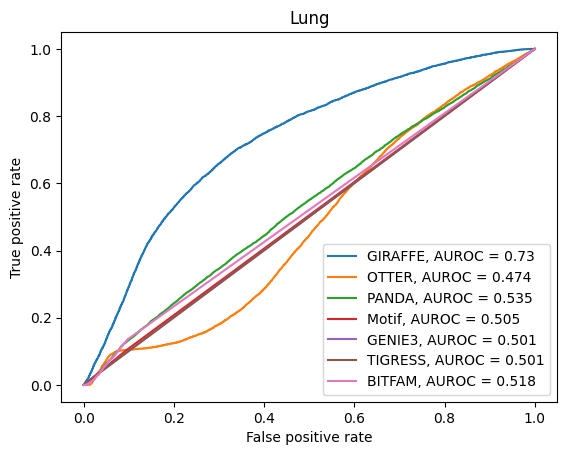

[0.73, 0.474, 0.535, 0.505, 0.501, 0.501, 0.518]

In [11]:
notebooks.utils.plot_auroc(chip.to_numpy().flatten(), 
                          [R_giraffe.to_numpy().flatten(), R_otter.to_numpy().flatten(), R_panda.to_numpy().flatten(), motif.to_numpy().flatten(), R_tigress.to_numpy().flatten(), R_tigress.to_numpy().flatten(), R_bitfam.to_numpy().flatten()],
                          ["GIRAFFE", "OTTER", "PANDA", "Motif", "GENIE3", "TIGRESS", "BITFAM"], "Lung")

## 3. Adjusting for ischemic time

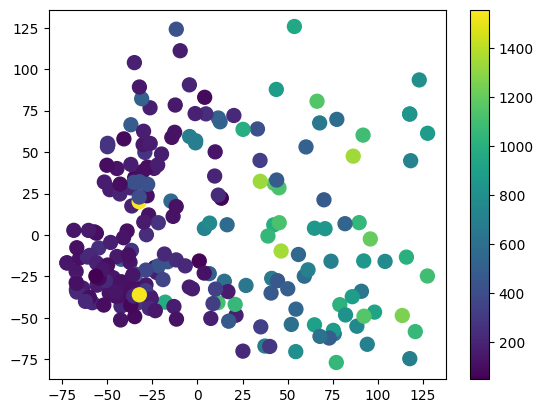

In [14]:
from sklearn.decomposition import PCA
a = pd.read_csv("data/lung/raw/ischemic.txt", sep = '\t')
patients = list(a['Sample'])
ischemic = list(a['ischemic'])
b = expression.loc[:, patients]
pca = PCA(n_components=2)
components = pca.fit_transform(b.T)

f, ax = plt.subplots()
points = ax.scatter(components[:, 0], components[:, 1], c=a['ischemic'].to_numpy(), s=100)
f.colorbar(points)

In [15]:
a = pd.read_csv("data/lung/raw/ischemic.txt", sep = '\t')
patients = a['Sample']
ischemic = a['ischemic']
I = []
for p in expression.columns:
    if p in patients:
        I.append(list(ischemic)[list(patients).index(p)])
    else:
        I.append(np.mean(ischemic.to_numpy()))

In [16]:
if cache:
    expr_limma = pd.read_csv("data/lung/expression_limma.csv", index_col = 0)
else:
    expr_limma = notebooks.utils.limma(pd.DataFrame(I, columns = ['cf']), expression, 'cf', '~cf')
    expr_limma.to_csv("data/lung/expression_limma.csv")

In [17]:
if cache:
    R_giraffe_adj = pd.read_csv("data/lung/R_giraffe_adj.csv", index_col = 0)
else:
    R_giraffe_adj = giraffe.Giraffe(expression.to_numpy(), motif.to_numpy(), ppi.to_numpy() + np.eye(ppi.shape[0]), adjusting = np.asarray(I), save_computation = True).get_regulation()
    pd.DataFrame(R_giraffe, index = motif.index, columns = motif.columns).to_csv("data/lung/R_giraffe_adj.csv")

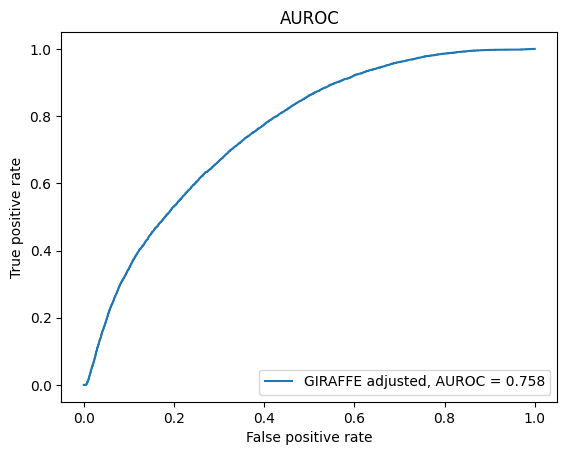

[0.758]

In [18]:
notebooks.plot_auroc(chip.to_numpy().flatten(), [R_giraffe_adj.to_numpy().flatten()], ['GIRAFFE adjusted'])

In [19]:
if cache:
    R_giraffe_limma = pd.read_csv("data/lung/R_giraffe_limma.csv", index_col = 0)
else:
    R_giraffe_limma = giraffe.Giraffe(expr_limma.to_numpy(), motif.to_numpy(), ppi.to_numpy() + np.eye(ppi.shape[0]), save_computation = True).get_regulation()
    pd.DataFrame(R_giraffe, index = motif.index, columns = motif.columns).to_csv("data/lung/R_giraffe_limma.csv")

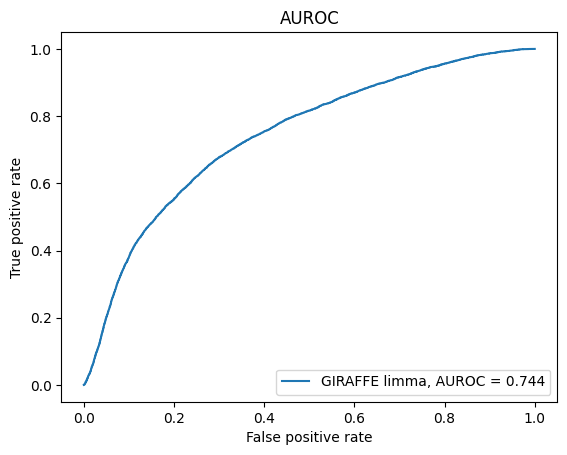

[0.744]

In [20]:
notebooks.plot_auroc(chip.to_numpy().flatten(), [R_giraffe_limma.to_numpy().flatten()], ['GIRAFFE limma'])